# J1 League 2024 시즌 데이터 기반 Soccermix 적용

본 노트북은 J1 League 2024 시즌 데이터에  
Soccermix(https://github.com/ML-KULeuven/soccermix)를 적용하는 실습 자료입니다.

In [ ]:
!git clone https://github.com/narame7/UOS-FootballDataAnalytics-Tutorial

In [ ]:
%cd 'UOS-FootballDataAnalytics-Tutorial/Week 13'

압축 해제

In [ ]:
import tarfile

tar_path = "/home/2025FDA/Week 13/data/JL.tar.gz"
extract_path = "/home/2025FDA/Week 13/data/uncompressed"


import os
os.makedirs(extract_path, exist_ok=True)

with tarfile.open(tar_path, "r:gz") as tar:
    tar.extractall(path=extract_path)

print("압축 풀기 완료!")


SyntaxError: invalid syntax (1998853896.py, line 1)

In [48]:
import os; import sys; sys.path.insert(0,'../')
import pandas as pd
import numpy as np
from tqdm import tqdm
import warnings
import socceraction.atomic.vaep.features as fs
import vis
import mixture as mix
import tqdm
import matplotsoccer as mps
import matplotlib.pyplot as plt

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


데이터 불러오기

In [65]:
games = pd.read_feather('../data/JL_games.feather')
data = pd.read_feather('../data/JL_events.feather')
print("nb of games:", len(games))

nb of games: 380


좌우 변환

In [ ]:
def flip_xy(raw_event_df: pd.DataFrame, games:pd.DataFrame):
    inversed_matches = raw_event_df.copy()
    
    # 각 경기의 홈 팀 정보 매핑
    game_home_dict = dict(zip(games['game_id'], games['home_team_id']))
    inversed_matches['is_home'] = inversed_matches['game_id'].map(game_home_dict) == inversed_matches['team_id']

    # 원정 경기(홈 아님)만 좌우반전
    away_mask = ~inversed_matches['is_home']

    inversed_matches.loc[away_mask, 'start_x'] = 105 - inversed_matches.loc[away_mask, 'start_x']
    inversed_matches.loc[away_mask, 'end_x'] = 105 - inversed_matches.loc[away_mask, 'end_x']
    inversed_matches.loc[away_mask, 'start_y'] = 68 - inversed_matches.loc[away_mask, 'start_y']
    inversed_matches.loc[away_mask, 'end_y'] = 68 - inversed_matches.loc[away_mask, 'end_y']

    return inversed_matches

def simplify(actions):
    '''
    feature 범주 단순화
    '''
    a=actions.fillna(0)
    a["x"] = a["start_x"]
    a["y"] = a["start_y"]
    a["dx"] = a["end_x"] - a["start_x"]
    a["dy"] = a["end_y"] - a["start_y"]
    
    corner_idx = a.type_name.str.contains("corner")
    a["type_name"] = a["type_name"].mask(corner_idx,"corner")

    freekick_idx = a.type_name.str.contains("freekick")
    a["type_name"] = a["type_name"].mask(freekick_idx,"freekick")

    keeper_idx = a.type_name.str.contains("keeper")
    a["type_name"] = a["type_name"].mask(keeper_idx,"keeper_catch")

    a["x"] = a.x.mask(a.type_name=="goalkick",5)
    a["y"] = a.y.mask(a.type_name=="goalkick",32.5)
    
    a["x"] = a.x.mask(a.type_name=="goal",105)
    a["y"] = a.y.mask(a.type_name=="goal",34)
    a["x"] = a.x.mask(a.type_name=="shot_penalty",94.5)
    a["y"] = a.y.mask(a.type_name=="shot_penalty",34)
    
    def fix_out_y(y):
        return 68 if 68 - y < y else 0

    a["y"] = a.y.mask(a.type_name=="out",a.y.apply(fix_out_y))
    
    return a

def add_noise(a):
    '''
    약한 랜덤 이동
    '''
    a["x"] = a.x + np.random.normal(0,1,len(a))
    a["y"] = a.y + np.random.normal(0,1,len(a))
    #a["dx"] = a.dx + (a.dx != 0).apply(int) * np.random.normal(0,1,len(a))
    #a["dy"] = a.dy + (a.dy != 0).apply(int) * np.random.normal(0,1,len(a))
    a["dx"] = a.dx + np.random.normal(0,1,len(a))
    a["dy"] = a.dy + np.random.normal(0,1,len(a))
    return a


In [66]:
final_df = flip_xy(data, games)
a = final_df[100000:150000] # 시간 단축을 위해 일부만 추출
a = simplify(a)
a = add_noise(a)
a = pd.concat([a,fs.movement_polar(a)],axis=1) # add polar movement direction
a

game_id                     original_event_id  period_id  \
100000  3925538.0  ca9ec30e-643d-4b0c-b424-b587c3ea7e3a          1   
100001  3925538.0  c28ba1cf-b923-4abb-a2f7-80c8d7f70a74          1   
100002  3925538.0  4e08f8cc-2a04-4d91-be32-39e7fe6c2cfd          1   
100003  3925538.0  ff780228-6e02-45fa-a8a3-92616bc514c1          1   
100004  3925538.0  532c1136-3f8a-42a3-adac-f9977d8deaea          1   
...           ...                                   ...        ...   
149995  3925414.0  7dbba6d4-3bfa-4b02-ad41-87eb7cfe0bc4          1   
149996  3925414.0  3988778d-f5bc-4652-b001-33a180ad4c27          1   
149997  3925414.0  4438e6fb-b1ed-482d-9bcb-fa545248d5f8          1   
149998  3925414.0  216c5e76-2595-4a13-9611-42b96196752c          1   
149999  3925414.0  1b7e3cbc-170a-47b3-998c-fa72c5a6bf49          1   

        time_seconds  team_id  player_id   start_x  start_y     end_x  \
100000      2288.581   4629.0    94164.0  46.24375  24.0975  87.01875   
100001      2291.573   4629.0    94173.0  87.01875  46.3675  82.11875   
100002      2294.953   4629.0    94173.0  82.11875  59.6275  71.70625   
100003      2295.789   4629.0    99944.0  71.70625  60.0525  72.14375   
100004      2299.473   4629.0    99944.0  72.14375  45.0075  82.29375   
...              ...      ...        ...       ...      ...       ...   
149995       926.659   4631.0    38536.0  19.03125  36.9325   8.88125   
149996       928.299   4631.0    37658.0   8.88125  29.5375  43.09375   
149997       929.933   1894.0    37246.0  61.90625  26.1375  70.04375   
149998       931.711   1894.0   100366.0  70.04375  43.7325  71.09375   
149999       932.853   1894.0   100366.0  71.09375  46.7075  85.70625   

          end_y  ...  bodypart_id  action_id  type_name  is_home          x  \
100000  46.3675  ...            5        868       pass    False  45.124655   
100001  59.6275  ...            0        869    dribble    False  85.474114   
100002  60.0525  ...            5        870       pass    False  80.607942   
100003  45.0075  ...            0        871    dribble    False  72.489271   
100004  39.5675  ...            5        872       pass    False  73.797296   
...         ...  ...          ...        ...        ...      ...        ...   
149995  29.7925  ...            5        216       pass    False  19.107681   
149996  41.8625  ...            5        217       pass    False   8.110765   
149997  43.7325  ...            1        218       pass     True  61.020878   
149998  46.7075  ...            0        219    dribble     True  70.698049   
149999  58.0125  ...            4        220       pass     True  70.927594   

                y         dx         dy   mov_d_a0  mov_angle_a0  
100000  24.175713  42.494145  22.067532  47.882443      0.478974  
100001  47.181364  -4.195416  13.159904  13.812479      1.879413  
100002  60.144384 -11.077367  -0.327418  11.082205     -3.112044  
100003  60.321200   0.762535 -13.875230  13.896168     -1.515895  
100004  46.616039  10.516762  -4.716269  11.525861     -0.421566  
...           ...        ...        ...        ...           ...  
149995  35.998718  -9.827756  -9.663427  13.782838     -2.364625  
149996  27.831159  34.424039  12.013406  36.460066      0.335769  
149997  26.004164  10.250997  17.729318  20.479542      1.046565  
149998  44.374535   0.960620   5.454072   5.538023      1.396455  
149999  46.464936  15.660738  11.611941  19.496048      0.638018  

[50000 rows x 22 columns]

In [9]:
'''
cat_weights:
  CategoricalModel.predict_proba 결과로 생성된 행동 확률 테이블.
  여기서는 (X == c) 여부만 반영되었기 때문에,
  각 이벤트 타입이 등장한 횟수를 column별로 합산한 값이 됨.

이 정보는 이후 GMM(MultiGauss, VonMises) 등 분포 모델 학습 시
  - 각 이벤트 유형의 샘플 가중치
  - 행동 그래프 구축(어떤 행동이 얼마나 자주 발생하는지)
에 사용됨.
'''
cat_model = mix.CategoricalModel()
cat_model.fit(a["type_name"])
cat_weights = cat_model.predict_proba(a["type_name"])
cat_weights.sum()

throw_in         1113.0
pass            21714.0
keeper_catch      326.0
shot              689.0
interception      674.0
bad_touch         669.0
corner            246.0
tackle            732.0
freekick          660.0
goalkick          430.0
clearance        1191.0
take_on           572.0
dribble         19690.0
cross             617.0
foul              673.0
shot_penalty        4.0
dtype: float64

In [10]:
from sklearn.neighbors import LocalOutlierFactor as LOF
'''
LocalOutlierFactor 기반 이벤트 좌표(outlier) 제거
- 각 이벤트 유형(column)별로 독립적으로 LOF 수행
- 좌표(x,y)가 이상치로 판단되면 해당 이벤트 가중치(weight)를 0으로 설정
- 행동 분포를 왜곡시키는 극단값을 제거
'''

def remove_outliers(X,weights,tol=1e-4):
    new_weights = pd.DataFrame()
    for column in weights.columns:
        idx = weights[column] > tol
        if idx.sum() < 2:
            # 샘플이 1개거나 0개면 LOF 적용 못 함 → 원본 유지
            continue
        c = LOF(contamination="auto").fit_predict(X[idx])
        idx[idx] = c == 1
        new_weights[column] = weights[column].mask(~idx, 0)
    return new_weights

X = a[["x","y"]]
cat_weights = remove_outliers(X,cat_weights)
cat_weights.sum()

/opt/conda/envs/soccermix/lib/python3.8/site-packages/sklearn/neighbors/_lof.py:283: UserWarning: n_neighbors (20) is greater than the total number of samples (4). n_neighbors will be set to (n_samples - 1) for estimation.
  warnings.warn(


throw_in         1110.0
pass            21698.0
keeper_catch      306.0
shot              669.0
interception      672.0
bad_touch         664.0
corner            229.0
tackle            732.0
freekick          660.0
goalkick          416.0
clearance        1172.0
take_on           571.0
dribble         19663.0
cross             614.0
foul              672.0
shot_penalty        4.0
dtype: float64

experiments는 학습시킬 모델들의 설정값을 담고 있는 리스트
- 딕셔너리들의 리스트 형태
- 각 딕셔너리는 어떤 액션을 몇 개의 덩어리로 분석할지 정보를 담고 있음

In [11]:
experiments = list([dict(name=name,n_components=i,distribution=mix.MultiGauss)
               for name in set(cat_weights.columns)
               for i in range(1,10)])
experiments += list([dict(name=name,n_components=i,distribution=mix.MultiGauss) # pass/dribble 같은 대량 이벤트는 더 세밀하게
               for name in ["pass","dribble"] 
               for i in range(10,30)])
experiments

[{'name': 'throw_in', 'n_components': 1, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 2, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 3, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 4, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 5, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 6, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 7, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 8, 'distribution': mixture.MultiGauss},
 {'name': 'throw_in', 'n_components': 9, 'distribution': mixture.MultiGauss},
 {'name': 'pass', 'n_components': 1, 'distribution': mixture.MultiGauss},
 {'name': 'pass', 'n_components': 2, 'distribution': mixture.MultiGauss},
 {'name': 'pass', 'n_components': 3, 'distribution': mixture.MultiGauss},
 {'name': 'pass', 'n_components': 4, 'distribution': mixture.MultiGauss},
 {

In [12]:
from dask.distributed import Client

def learn_mixture(X,W,experiment):
    model = mix.MixtureModel(n_components=experiment["n_components"],
                         distribution=experiment["distribution"])
    model = model.fit(X,weights=W[experiment["name"]].values)
    if model:
        model.name = experiment["name"]
    return model

def learn_mixture_models(X,W,experiments,distribution=mix.Gauss,verbose=True):
    """
    모든 experiment 설정을 순차적으로 돌면서
    여러 개의 mixture model을 학습하는 함수.

    → 로컬 CPU에서 순차 처리
    """
    models = []
    if verbose:
        experiments = tqdm.tqdm(experiments)
    for experiment in experiments:
        model = learn_mixture(X,W,experiment)
        if model:
            models.append(model)
    return models

def learn_mixture_models_dask(X,W,experiments,host="134.58.41.55:8786"):
    """
    Dask 분산 클러스터를 활용해 병렬 학습.

    host: Dask scheduler 주소
    """
    
    with Client(host) as client:
        client.upload_file("../mixture.py")
        X_fut = client.scatter(X, broadcast=True)
        W_fut = client.scatter(W, broadcast=True)
        
        futures = []
        for experiment in experiments:
            key = f"{experiment['name']}_{experiment['n_components']}"
            future = client.submit(learn_mixture,
                                   X_fut,
                                   W_fut,
                                   experiment,
                                   key=key)
            futures.append(future)
        models = client.gather(futures)
        return list(m for m in models if m)

In [13]:
X = a[["x","y"]]
loc_candidates = learn_mixture_models(X,cat_weights,experiments)
# loc_candidates = learn_mixture_models_dask(X,cat_weights,experiments)
len(loc_candidates)

  0%|          | 0/184 [00:00<?, ?it/s]

 73%|███████▎  | 135/184 [01:19<00:22,  2.21it/s]/home/2025FDA/Week 13/notebooks/../mixture.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.nan_to_num(np.cov(X.T, aweights=w), 0)
/opt/conda/envs/soccermix/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/envs/soccermix/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountered in multiply
  c *= np.true_divide(1, fact)
/home/2025FDA/Week 13/notebooks/../mixture.py:25: RuntimeWarning: Degrees of freedom <= 0 for slice
  self.cov = np.nan_to_num(np.cov(X.T, aweights=w), 0)
/opt/conda/envs/soccermix/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: divide by zero encountered in divide
  c *= np.true_divide(1, fact)
/opt/conda/envs/soccermix/lib/python3.8/site-packages/numpy/lib/function_base.py:2705: RuntimeWarning: invalid value encountere

179

## Inspect with strategies first

In [14]:
def inspect_strategies(candidates,max_components=10):
    """
    GMM 후보 모델(candidates)에 대해 여러 선택 전략을 비교하는 함수.
    
    
    출력:
      - 선택된 모델들의 total component 개수
      - 이벤트별 선택된 component 수 요약
    """
    for strategy in [mix.ilp_select_models_bic,
                     mix.select_models_solo_bic,
                     mix.ilp_select_models_bic_triangle,
                     lambda can : mix.ilp_select_models_max(can,max_components)]:
        models = strategy(candidates)
        print("total: ", sum(m.n_components for m in models))
        print({m.name : m.n_components for m in strategy(candidates) if m.n_components > 1})
# 전략 비교 실행
inspect_strategies(loc_candidates,50)

total:  72
{'throw_in': 4, 'keeper_catch': 2, 'cross': 4, 'shot': 2, 'bad_touch': 3, 'corner': 2, 'tackle': 6, 'freekick': 3, 'clearance': 3, 'take_on': 4, 'interception': 4, 'foul': 3, 'pass': 16, 'dribble': 14}
total:  91
{'throw_in': 4, 'pass': 16, 'keeper_catch': 3, 'shot': 2, 'interception': 4, 'bad_touch': 7, 'corner': 2, 'tackle': 6, 'freekick': 6, 'clearance': 3, 'take_on': 6, 'dribble': 16, 'cross': 5, 'foul': 6, 'shot_penalty': 4}
total:  33
{'throw_in': 2, 'pass': 7, 'keeper_catch': 2, 'cross': 2, 'corner': 2, 'clearance': 2, 'dribble': 7}
total:  50
{'throw_in': 2, 'pass': 9, 'keeper_catch': 2, 'cross': 2, 'bad_touch': 3, 'corner': 2, 'tackle': 3, 'freekick': 3, 'clearance': 3, 'take_on': 3, 'interception': 2, 'foul': 3, 'dribble': 10}


/opt/conda/envs/soccermix/lib/python3.8/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 1 times so far.

  warnings.warn(msg, UserWarning)
/opt/conda/envs/soccermix/lib/python3.8/site-packages/cvxpy/expressions/expression.py:650: UserWarning: 
This use of ``*`` has resulted in matrix multiplication.
Using ``*`` for matrix multiplication has been deprecated since CVXPY 1.1.
    Use ``*`` for matrix-scalar and vector-scalar multiplication.
    Use ``@`` for matrix-matrix and matrix-vector multiplication.
    Use ``multiply`` for elementwise multiplication.
This code path has been hit 2 times so far.

  warnings.warn(msg, UserWarning

throw_in 4


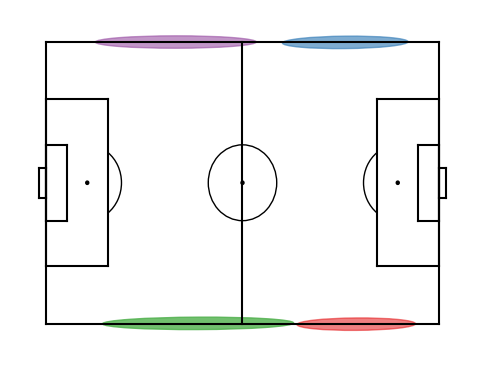

keeper_catch 2


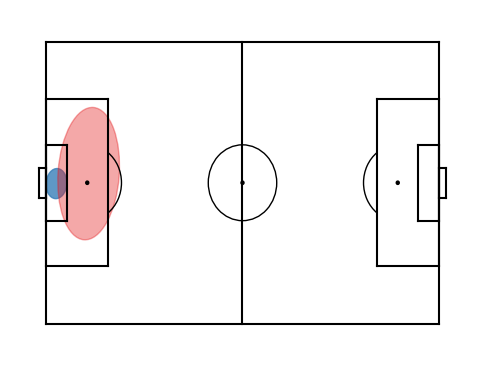

cross 4


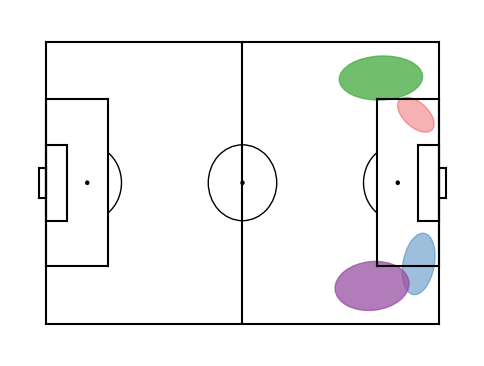

shot 2


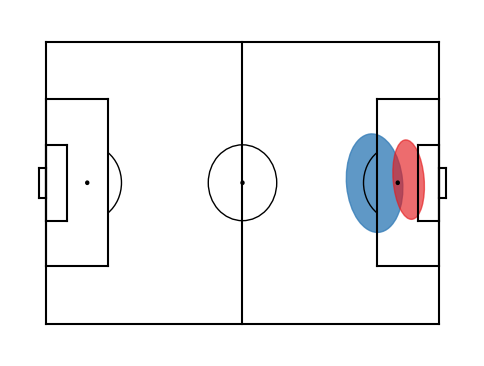

bad_touch 3


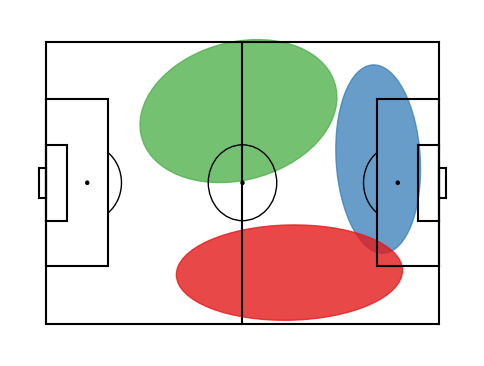

corner 2


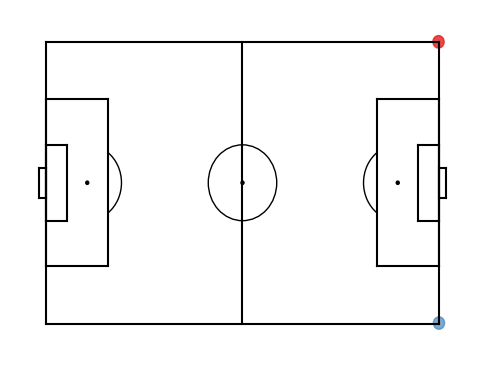

tackle 6


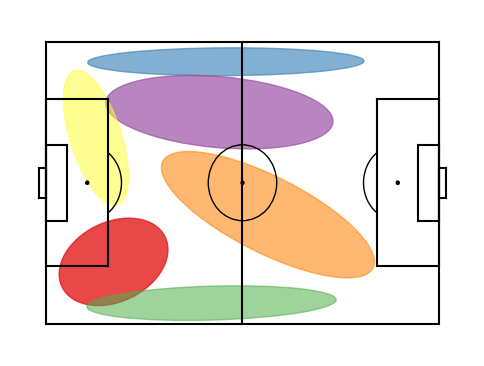

freekick 3


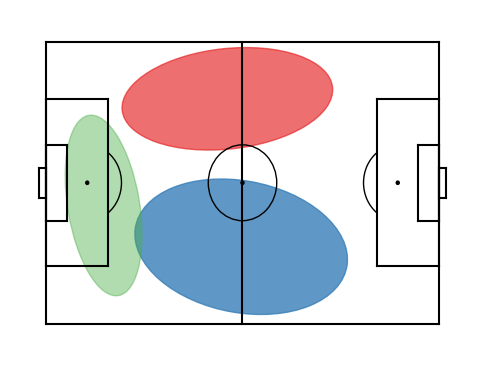

goalkick 1


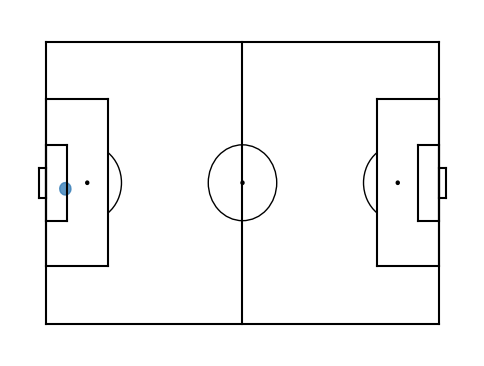

clearance 3


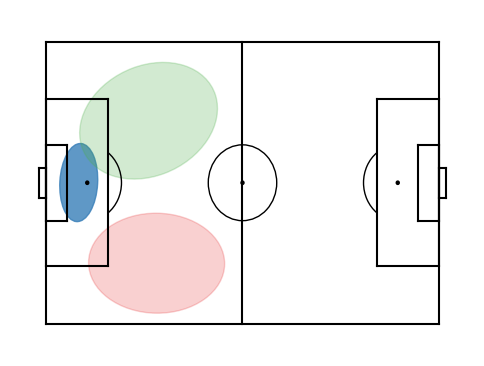

take_on 4


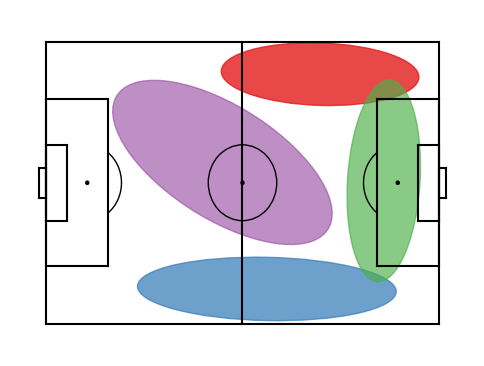

interception 4


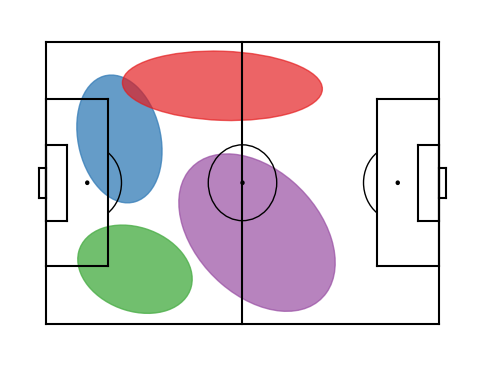

foul 3


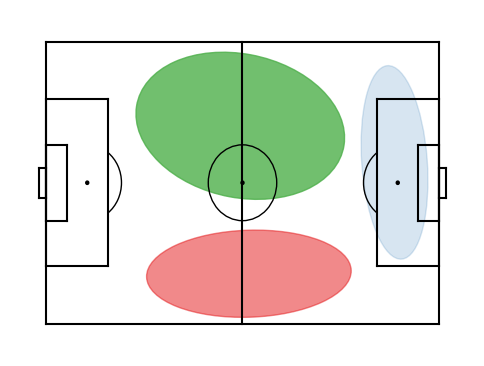

shot_penalty 1


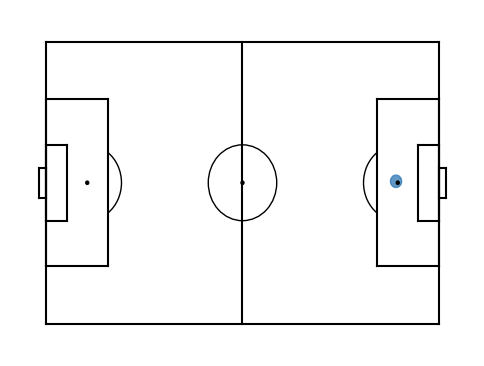

pass 16


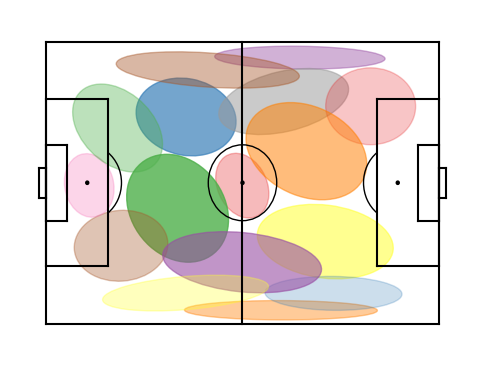

dribble 14


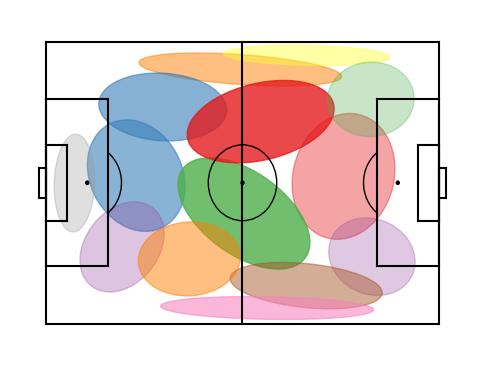

In [15]:
# 선택된 모델 기반 각 이벤트 타입별 위치 확률 분포 시각화
import warnings
warnings.filterwarnings("ignore", category=UserWarning, module="cvxpy")
vis.show_location_models(list(mix.ilp_select_models_bic(loc_candidates)))

throw_in 2


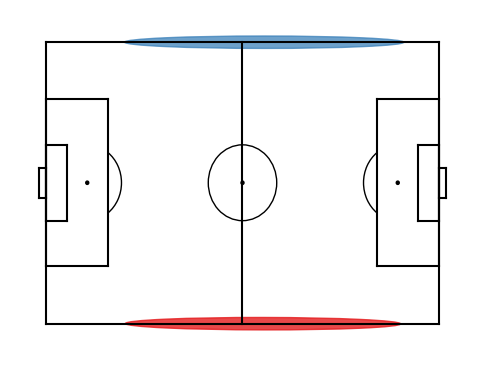

pass 7


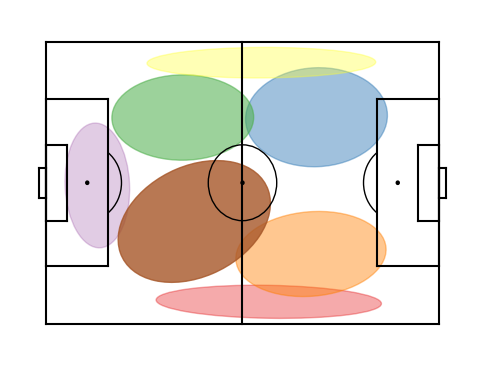

keeper_catch 2


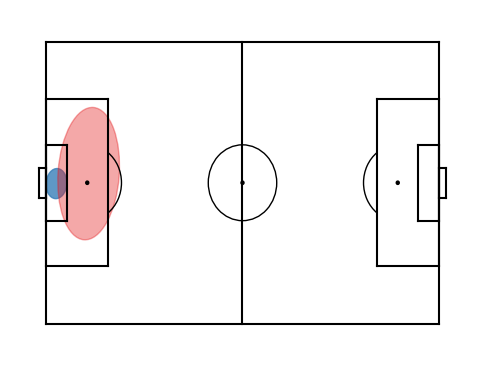

cross 2


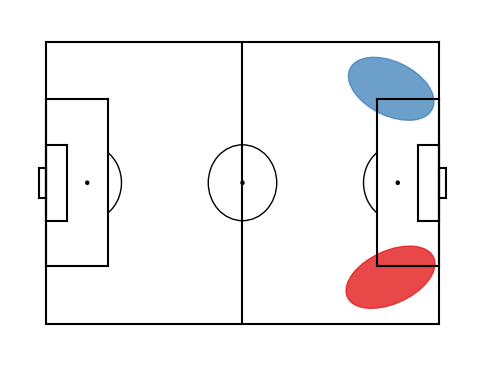

shot 1


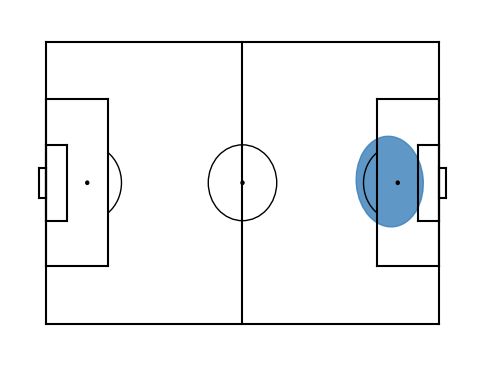

bad_touch 1


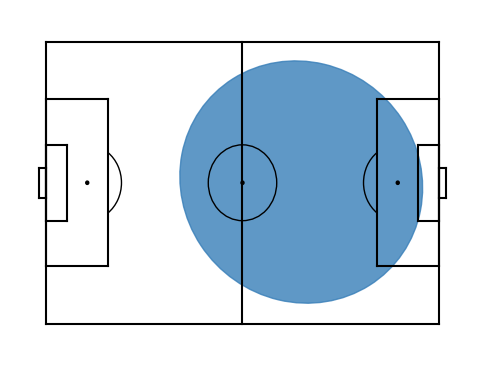

corner 2


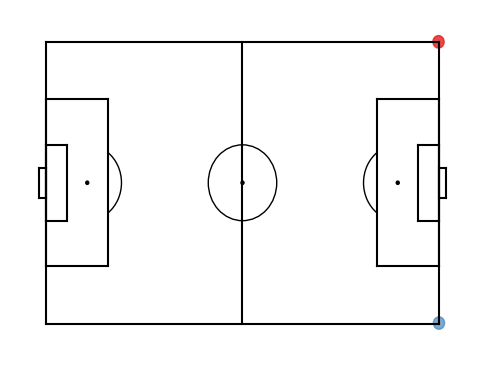

tackle 1


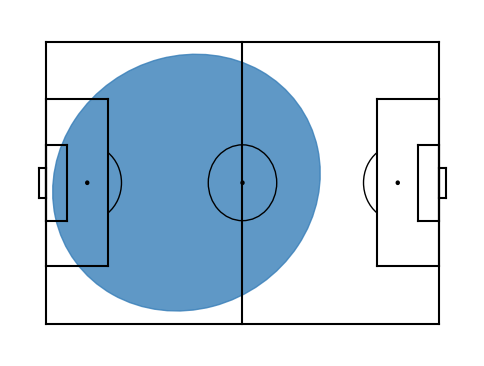

freekick 1


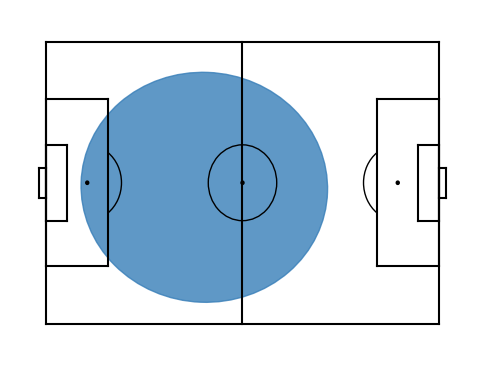

goalkick 1


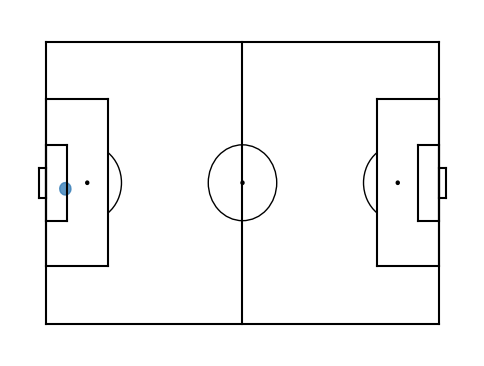

clearance 2


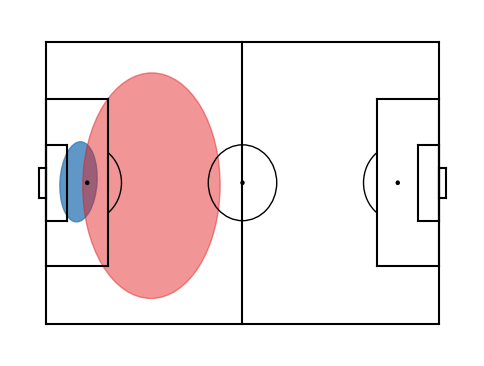

take_on 1


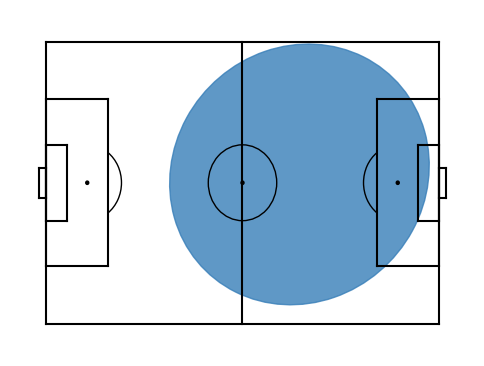

dribble 7


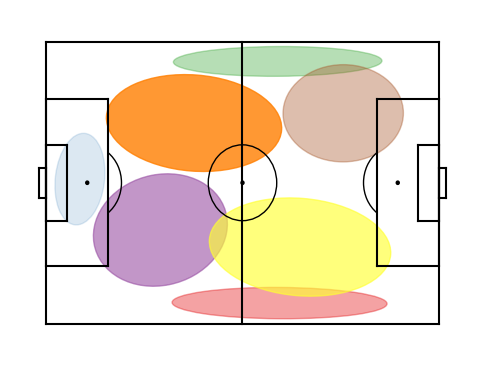

interception 1


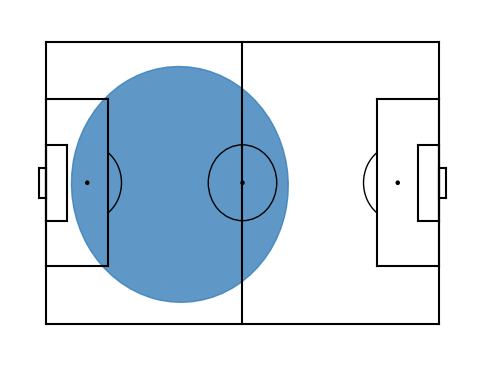

foul 1


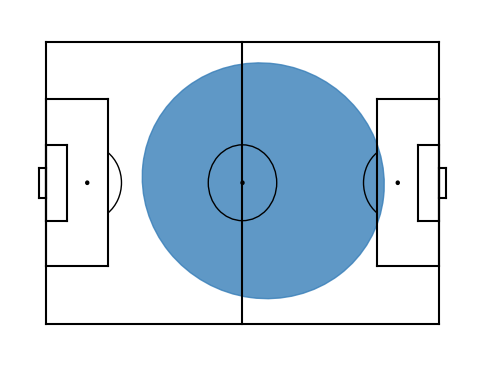

shot_penalty 1


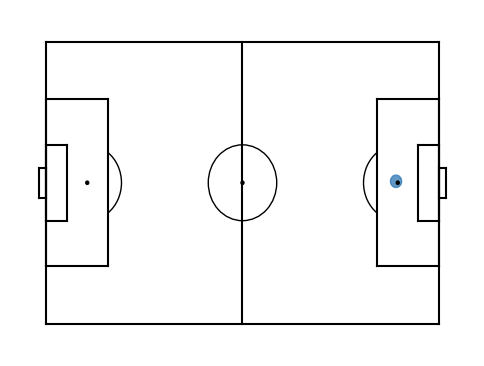

In [16]:
vis.show_location_models(list(mix.ilp_select_models_bic_triangle(loc_candidates))) 
# BIC + 추가 복잡도 패널티를 목적으로 하여 더 적은 component 선택

throw_in 4


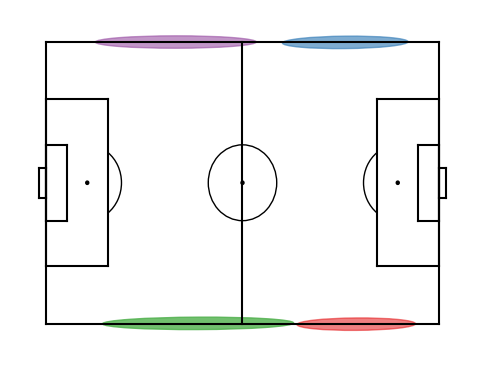

pass 16


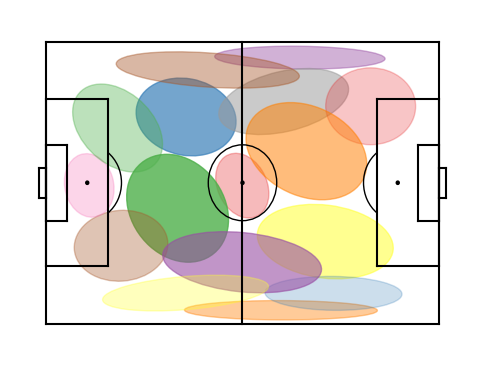

keeper_catch 3


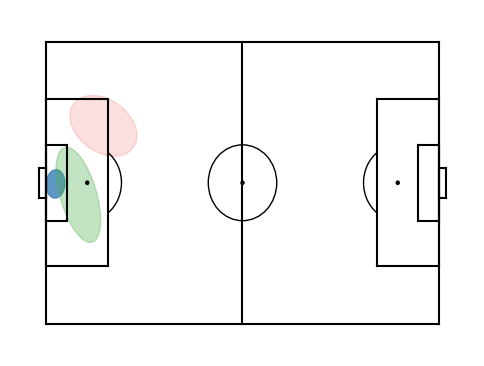

shot 2


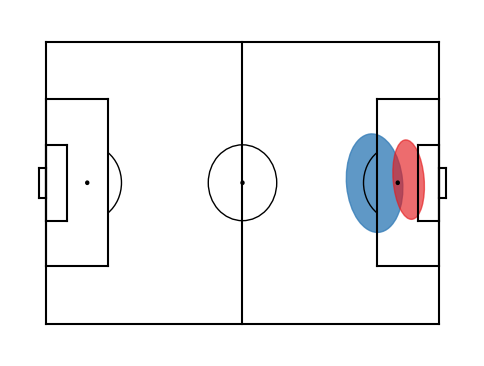

interception 4


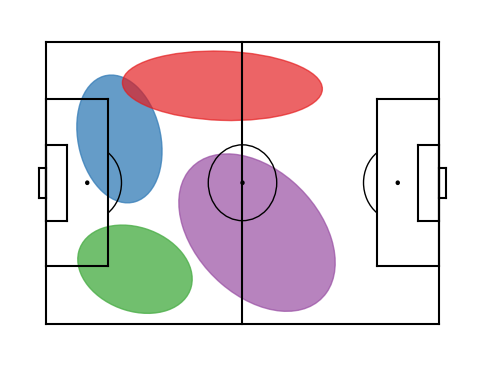

bad_touch 7


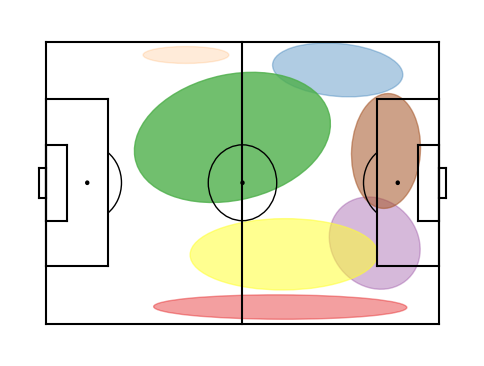

corner 2


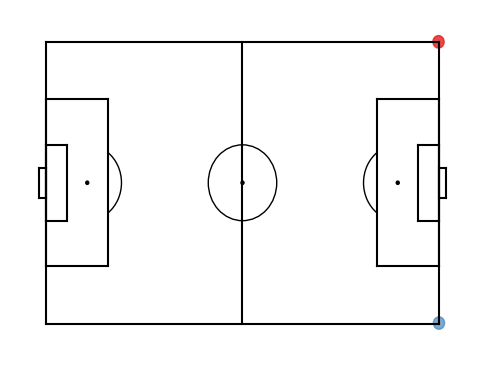

tackle 6


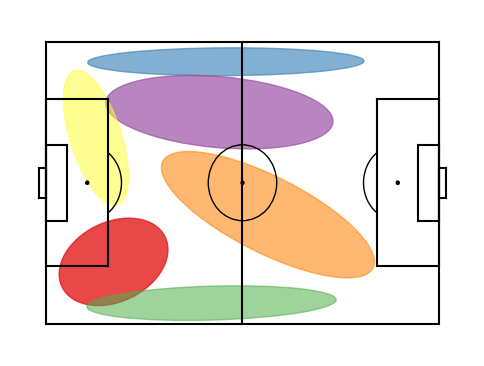

freekick 6


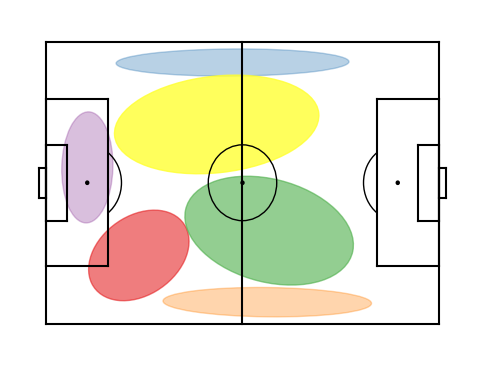

goalkick 1


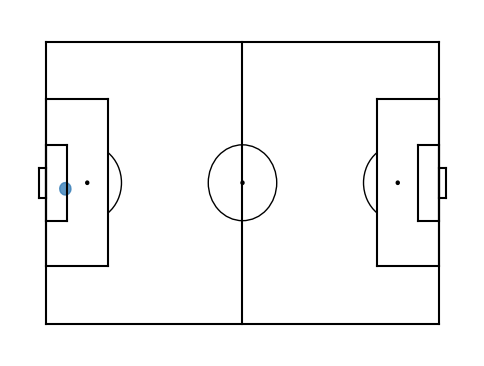

clearance 3


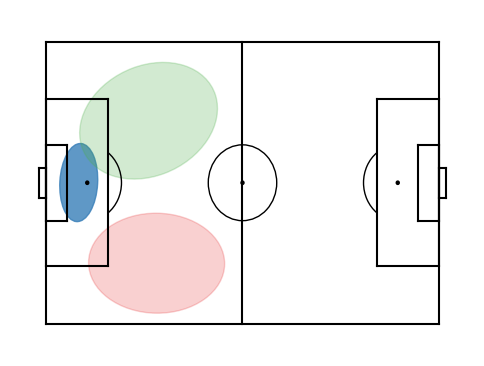

take_on 6


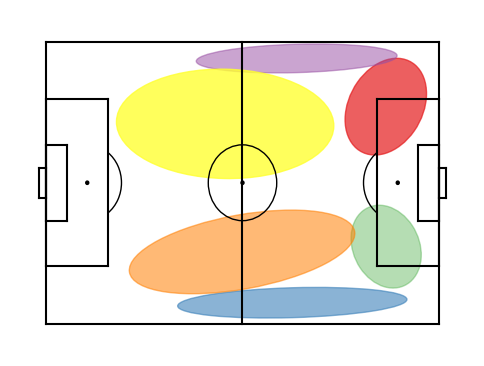

dribble 16


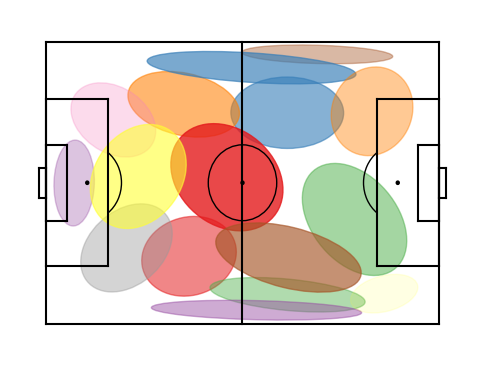

cross 5


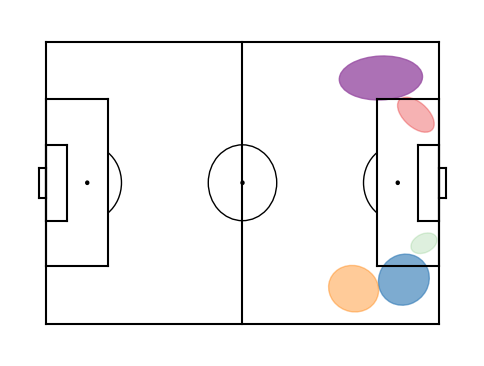

foul 6


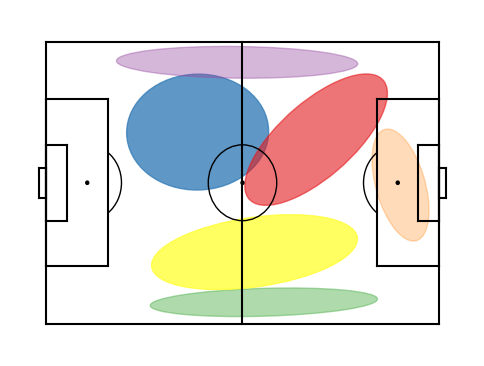

shot_penalty 4


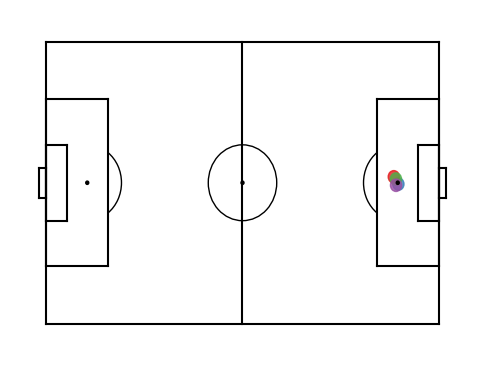

In [17]:
vis.show_location_models(list(mix.select_models_solo_bic(loc_candidates)))
# 전역 최적화가 아닌, 개별 최소화로 모델을 선택하는 방식

## Optimize number of clusters

In [18]:
'''
solo BIC 계산 및 비교 출력
- 각 이벤트 타입에 대해 다른 모델들과 독립적으로 BIC 점수가 최소가 되는 n_components 선택에 사용

해석:
 - solo_bic = log(N) * (#params) - 2 * loglikelihood, 이 값이 작을수록 모델이 더 적합 
'''
for m in loc_candidates:
    m.solo_bic = np.log(m.weight_total) * m._n_parameters() - 2*m.loglikelihood
    print(m.name, m.n_components, m.solo_bic)

throw_in 1 21371.879183627785
throw_in 2 15162.054934064045
throw_in 3 15113.171322177372
throw_in 4 15027.504454305079
throw_in 5 15047.431637547856
throw_in 6 15054.514228644568
throw_in 7 15080.986549177496
throw_in 8 15107.866752936701
throw_in 9 15127.087325256405
pass 1 389660.7409721188
pass 2 388222.9973704258
pass 3 383135.46814026777
pass 4 381628.4202255899
pass 5 381296.24200234126
pass 6 380893.0962365409
pass 7 379710.1658186442
pass 8 379480.43455528724
pass 9 379422.0972230981
keeper_catch 1 3936.127614254857
keeper_catch 2 3555.5730853395908
keeper_catch 3 3546.998952242168
keeper_catch 4 3551.9482323273905
keeper_catch 5 3577.4922488702587
keeper_catch 6 3606.649592628187
keeper_catch 7 3633.718831371
keeper_catch 8 3658.986727540163
keeper_catch 9 3679.714009771168
cross 1 9941.999796875178
cross 2 8899.177727291095
cross 3 8853.989353891808
cross 4 8783.481338915086
cross 5 8782.035274400321
cross 6 8809.969426233794
cross 7 8830.052981156112
cross 8 8851.8648704279

pass
16


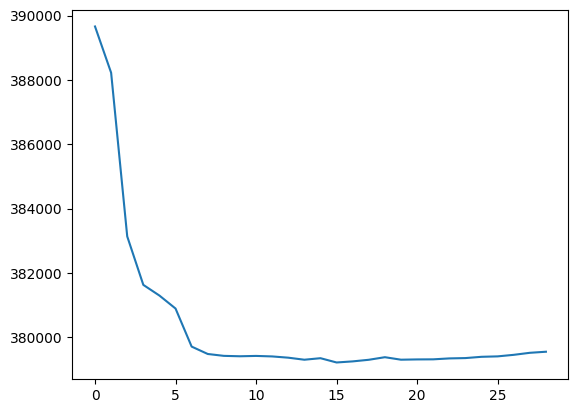

dribble
16


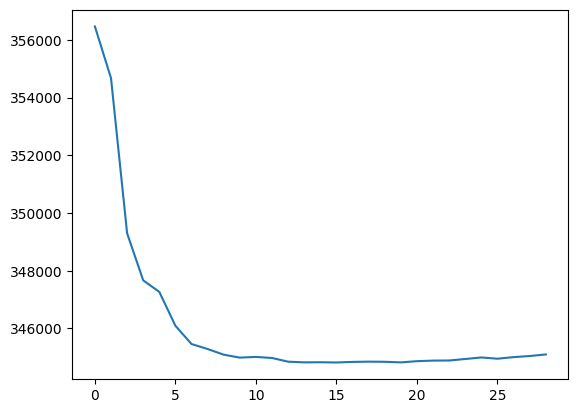

clearance
3


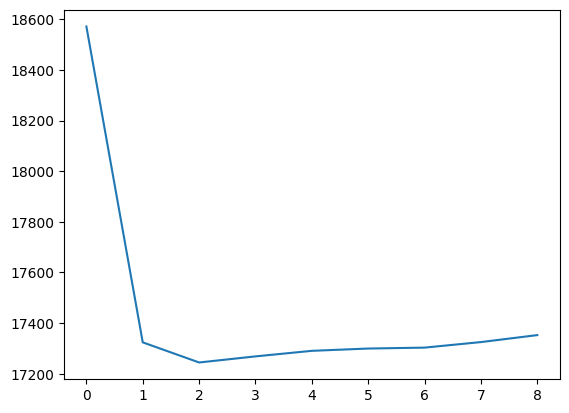

corner
2


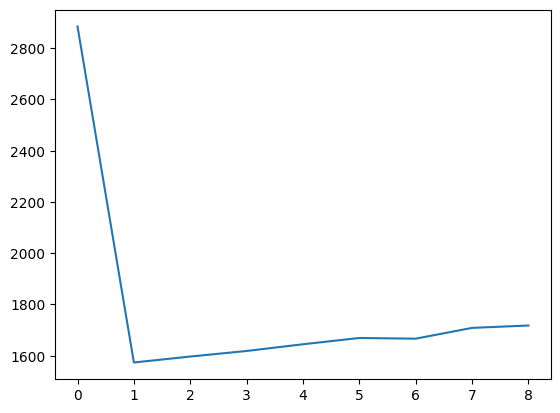

cross
5


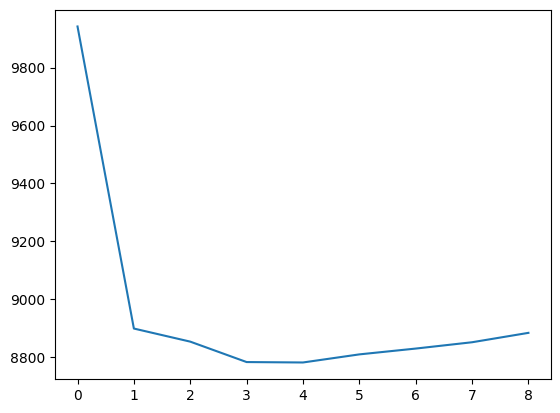

shot
2


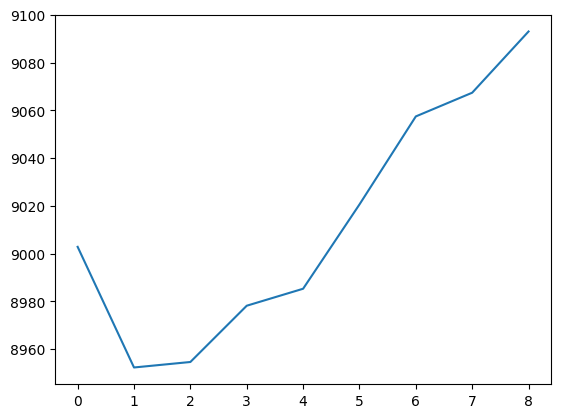

foul
6


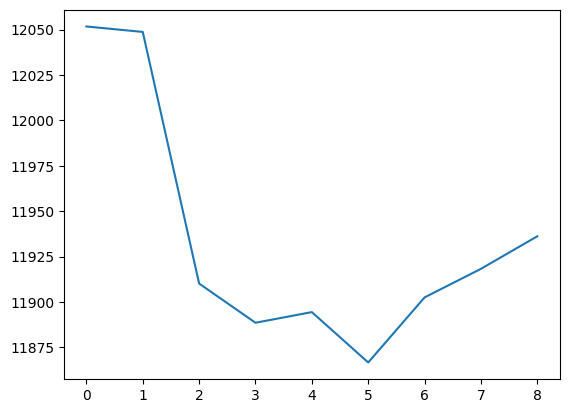

freekick
6


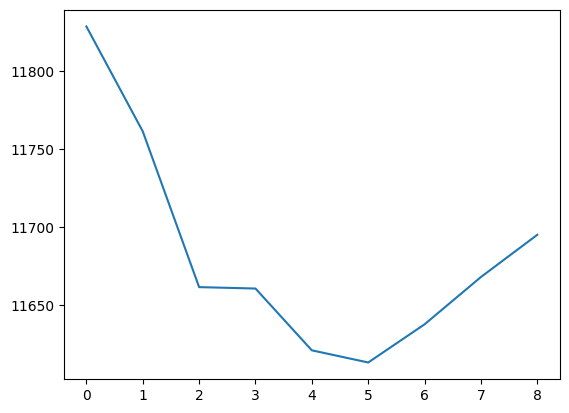

throw_in
4


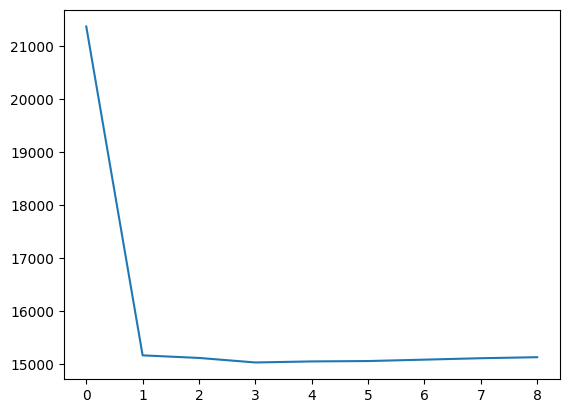

take_on
6


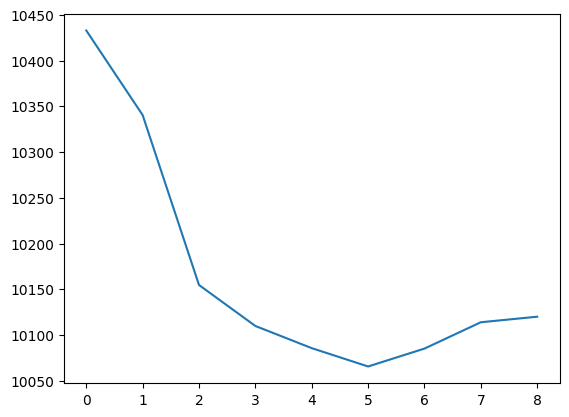

interception
4


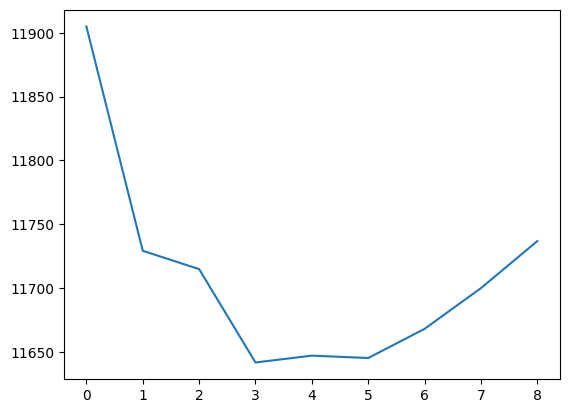

tackle
6


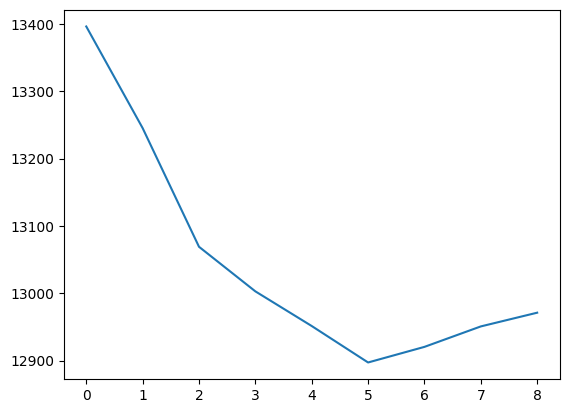

goalkick
1


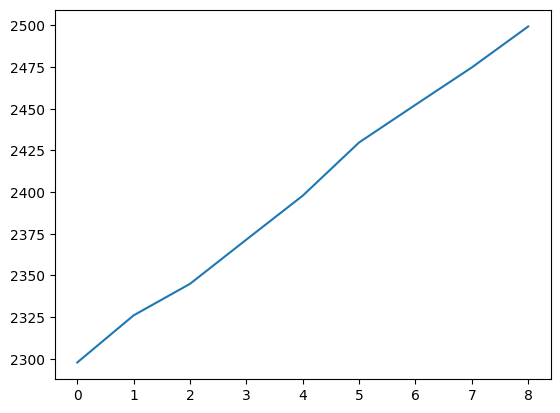

keeper_catch
3


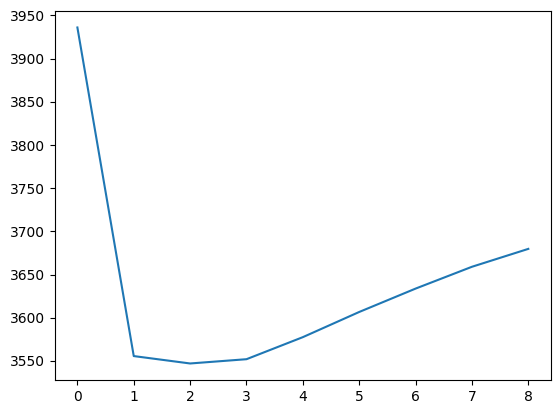

bad_touch
7


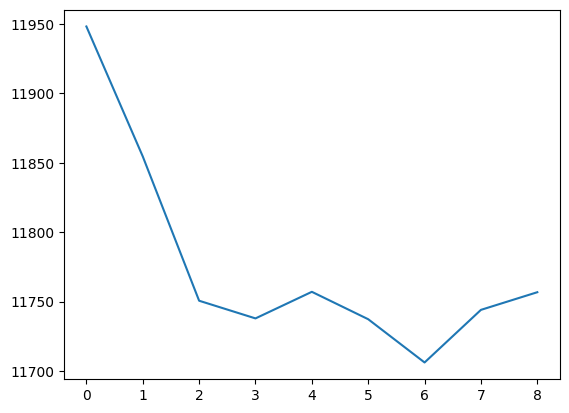

shot_penalty
4


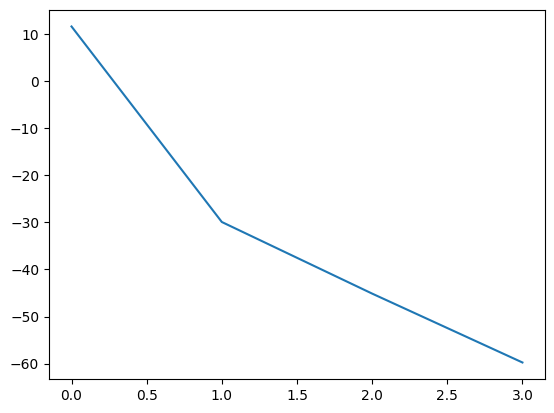

In [19]:
# 최적 클러스터를 찾기 위한 꺾은선 그래프
for l in a["type_name"].unique():
    bic_scores = []
    for m in loc_candidates:
        if (m.name == l):
            bic_scores.append(m.solo_bic)
            
    print(l)
    print(np.argmin(bic_scores)+1)
    plt.figure()
    plt.plot(range(0,len(bic_scores)), bic_scores)
    plt.show()

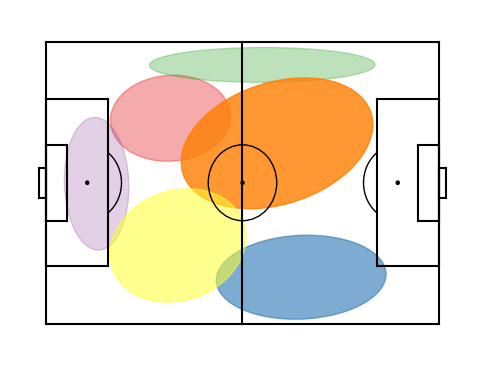

In [20]:
# visualize a specific location model
name = "pass"
n_comp = 6

for m in loc_candidates:
    if ((m.name == name) & (m.n_components == n_comp)):
        model = m
        break
        
vis.show_location_model(model)

## Make selection

In [21]:
# - loc_ultimate_selection은 각 이벤트 유형마다 최종적으로 선택한 GMM component 수를 정의한 목록
# - 이는 여러 후보에 대해 모델 선택 전략(BIC, ILP, inspections 등)을 비교한 뒤
#   전술적 해석 가능성과 데이터 안정성을 고려하여 도출된 결과,
# - 임의로 수정해보기를 권함


loc_ultimate_selection = [
    ("goal" , 1),
    ("red_card" , 1),
    ("shot", 1),
    ("receival", 6), 
    ("keeper_catch", 6),
    ("goalkick" , 1),
    ("foul" , 1), 
    ("offside", 1),
    ("dribble", 7), 
    ("yellow_card", 3),
    ("corner", 2),
    ("cross" , 2),
    ("bad_touch", 1),
    ("take_on", 1),
    ("tackle" , 2),
    ("shot_penalty", 1),
    ("freekick", 2),
    ("owngoal", 1),
    ("throw_in", 2),
    ("clearance", 1),
    ("out", 4),
    ("pass", 7),
    ("interception", 2)
]
loc_models = [l for l in loc_candidates if ((l.name,l.n_components) in loc_ultimate_selection)]

throw_in 2


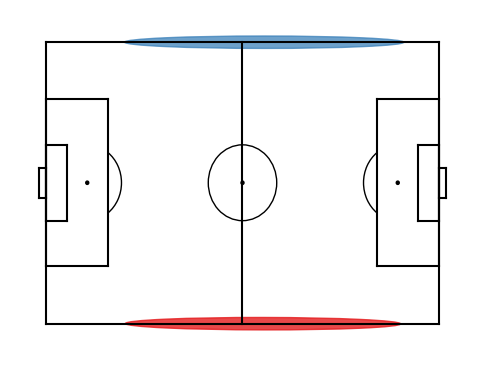

pass 7


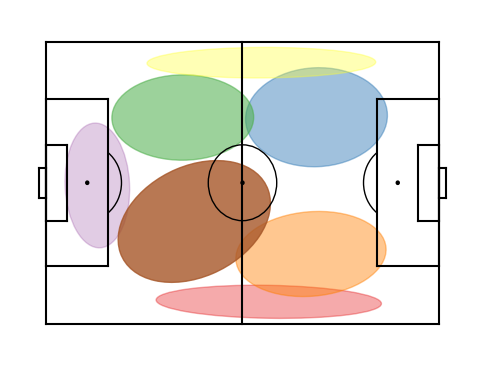

keeper_catch 6


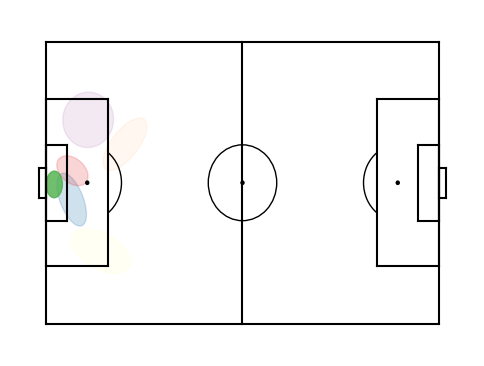

cross 2


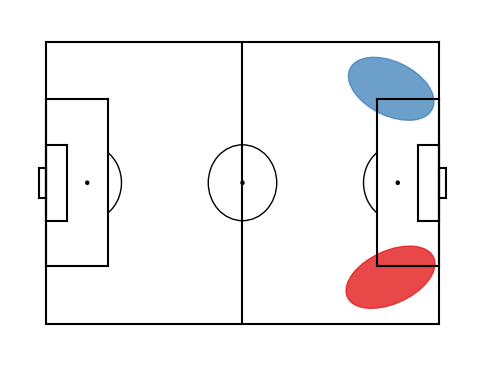

shot 1


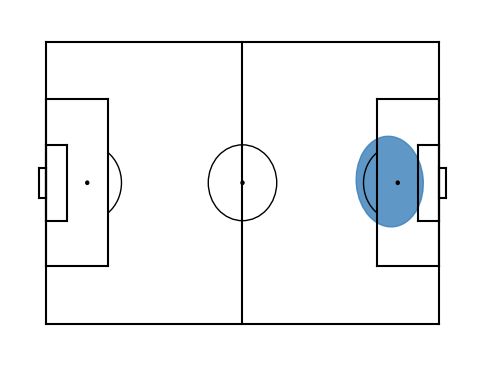

bad_touch 1


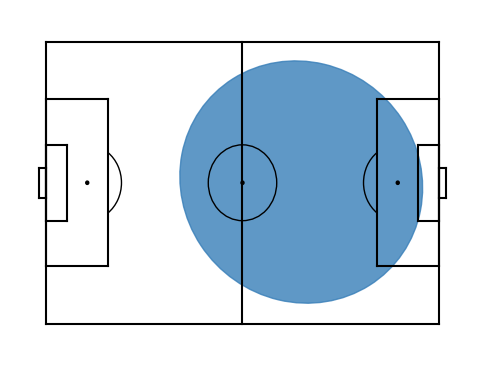

corner 2


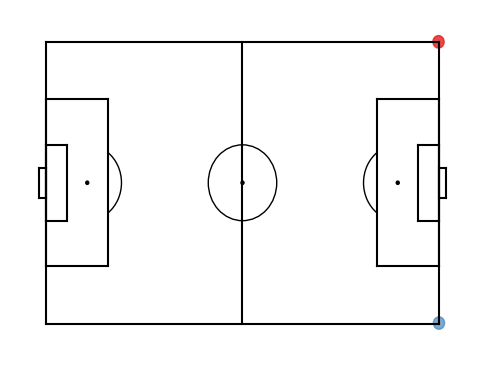

tackle 2


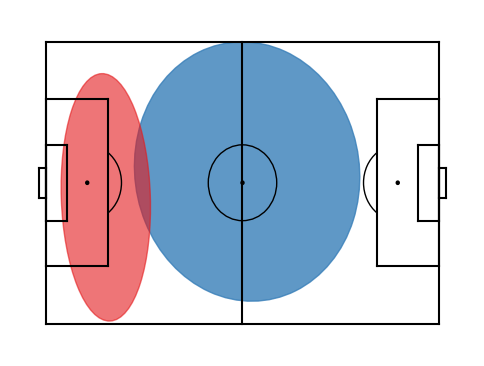

freekick 2


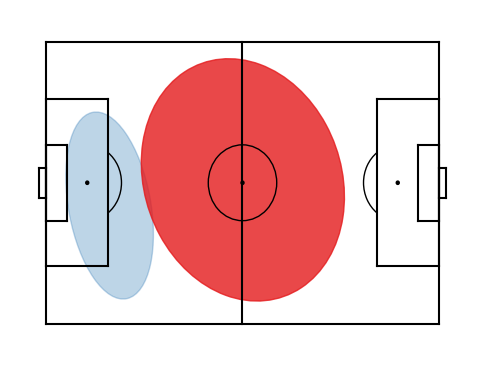

goalkick 1


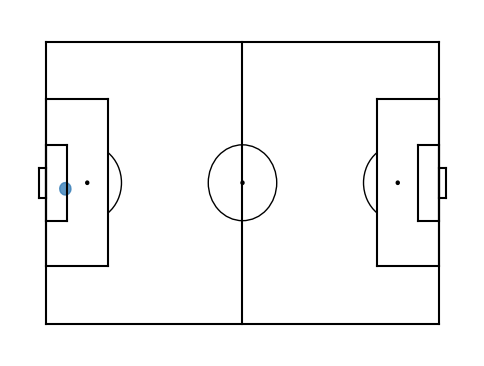

clearance 1


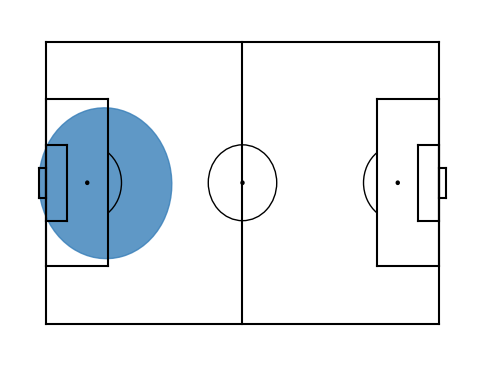

take_on 1


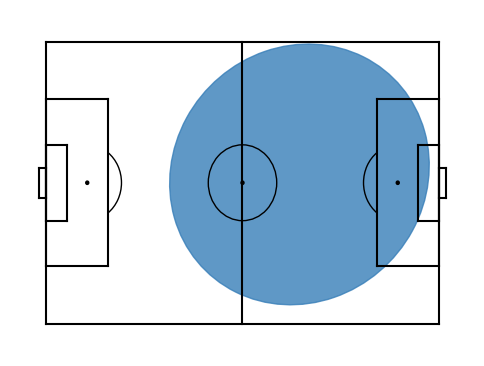

dribble 7


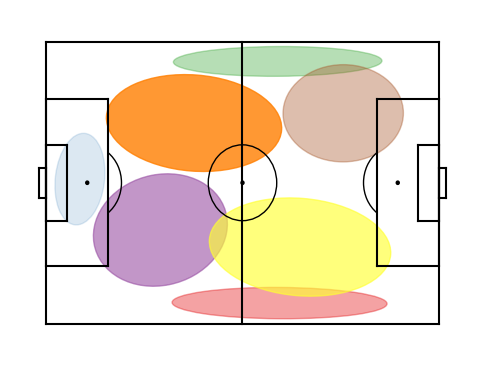

interception 2


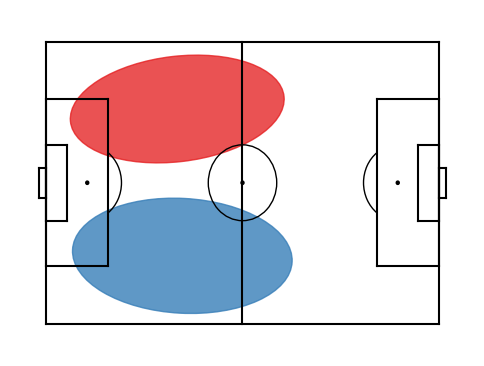

foul 1


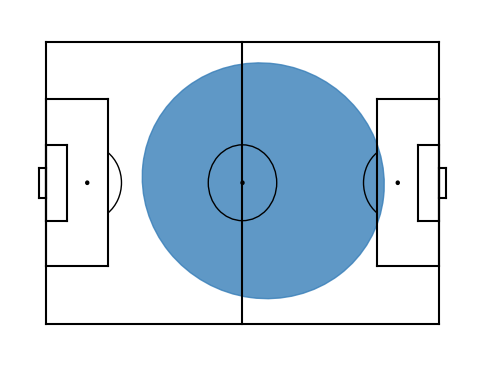

shot_penalty 1


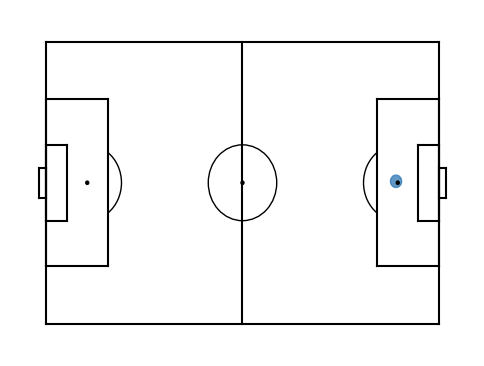

In [22]:
vis.show_location_models(loc_models)

In [23]:
loc_weights = mix.probabilities(loc_models,a[["x","y"]],cat_weights)

## Save Categorical and Location models

In [ ]:
import pickle
a = a.convert_dtypes()

for col in a.columns:
    if pd.api.types.is_integer_dtype(a[col]):
        a[col] = a[col].astype('int64')
    if a[col].dtype == 'object':
        a[col] = a[col].astype(str)
  
os.makedirs('../data', exist_ok=True)

# 모델 저장: 이벤트 유형 예측을 위한 Categorical Model
#     + 위치 GMM 모델들(loc_models)
file = open('../data/soccermix_J1_models.pkl', 'wb')
pickle.dump(cat_model, file)
pickle.dump(loc_models, file)
file.close()

# 후보 모델 저장: k값 후보들(전체 mixture 후보)
file2 = open('../data/soccermix_J1_candidates.pkl', 'wb')
pickle.dump(loc_candidates, file2)
file2.close()

# 이벤트 확률 저장 
#     — 각 이벤트가 특정 Action Type일 확률
data1 = open('../data/soccermix_J1_catweights.pkl', 'wb') 
s_cat_weights = cat_weights.astype(pd.SparseDtype("float", 0.0))
s_cat_weights.to_pickle(data1)
data1.close()

# 위치 확률(loc_weights) 저장 (Sparse 변환)
#     — 각 이벤트가 특정 spatial GMM cluster일 확률
data2 = open('../data/soccermix_J1_locweights.pkl', 'wb') 
s_loc_weights = loc_weights.astype(pd.SparseDtype("float", 0.0))
s_loc_weights.to_pickle(data2)
data2.close()

## Direction models
- 방향까지 포함한 클러스터링

In [25]:
experiments = [dict(name=name,n_components=i,distribution=mix.VonMises)
               for name in loc_weights.columns
               for i in range(1,10)]
len(experiments)

351

In [26]:
experiments

[{'name': 'throw_in_0', 'n_components': 1, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 2, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 3, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 4, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 5, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 6, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 7, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 8, 'distribution': mixture.VonMises},
 {'name': 'throw_in_0', 'n_components': 9, 'distribution': mixture.VonMises},
 {'name': 'throw_in_1', 'n_components': 1, 'distribution': mixture.VonMises},
 {'name': 'throw_in_1', 'n_components': 2, 'distribution': mixture.VonMises},
 {'name': 'throw_in_1', 'n_components': 3, 'distribution': mixture.VonMises},
 {'name': 'throw_in_1', 'n_components': 4, 'distribution': mixtu

In [27]:
a[["mov_angle_a0"]]

mov_angle_a0
100000      0.522732
100001      1.964435
100002      3.046176
100003     -1.527487
100004     -0.551443
...              ...
149995     -2.555672
149996      0.357634
149997      1.149292
149998      1.712795
149999       0.69847

[50000 rows x 1 columns]

In [28]:
# 5분정도 걸림..
X = a[["mov_angle_a0"]]
dir_candidates = learn_mixture_models(X,loc_weights,experiments)
len(dir_candidates)

  0%|          | 0/351 [00:00<?, ?it/s]

100%|██████████| 351/351 [04:40<00:00,  1.25it/s]


346

## Save Direction candidates

In [29]:
with open('../data/soccermix_J1_candidates.pkl','ab') as wfp:
    pickle.dump(dir_candidates, wfp)

## Inspect with strategies

throw_in 2


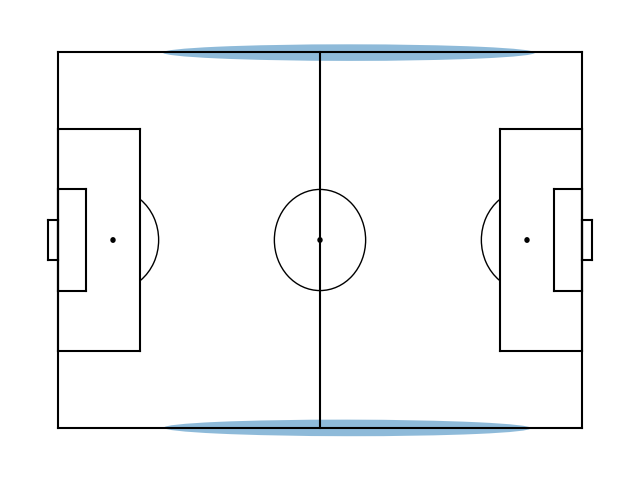

pass 7
pass_0 1
pass_1 1
pass_2 1
pass_3 1
pass_4 1
pass_5 2
pass_6 1


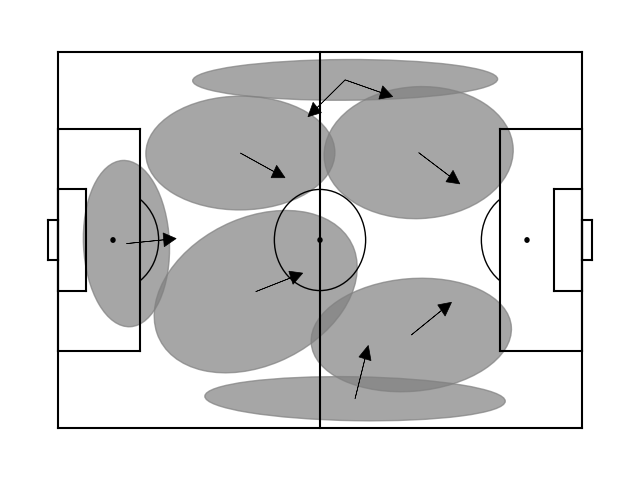

keeper_catch 6


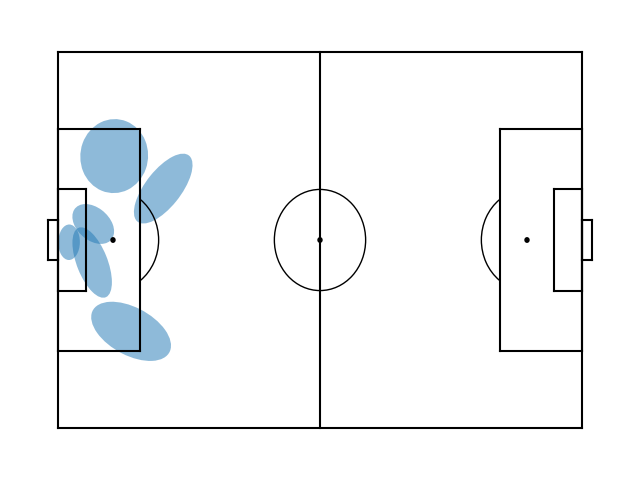

cross 2


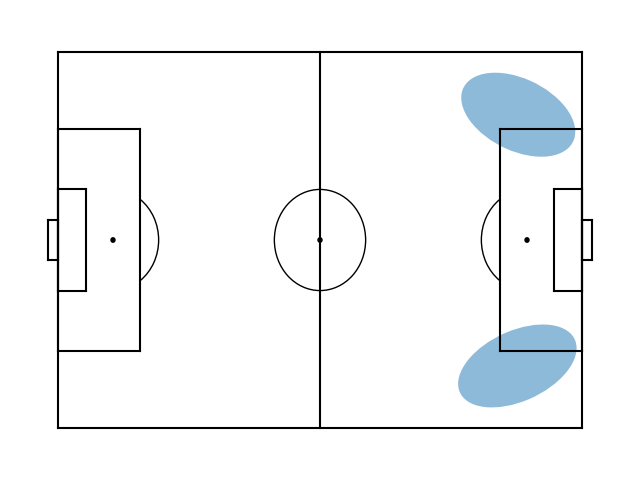

shot 1


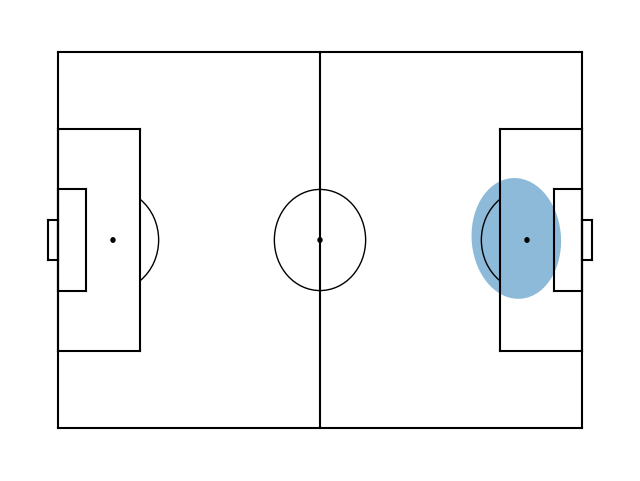

bad_touch 1


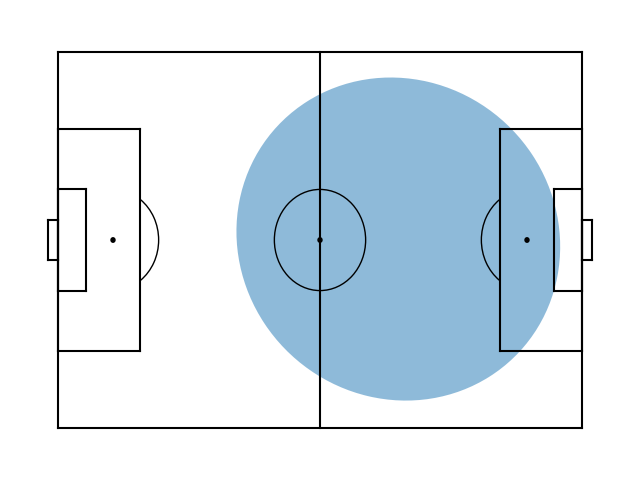

corner 2


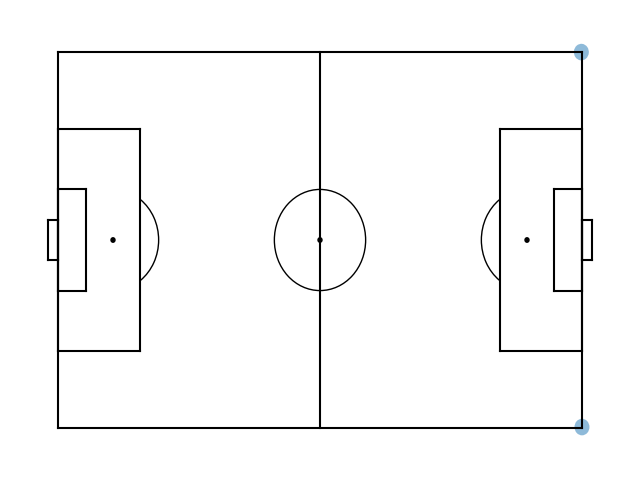

tackle 2


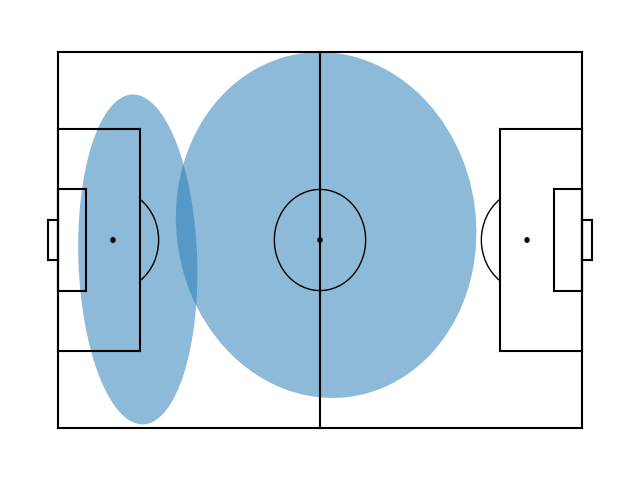

freekick 2


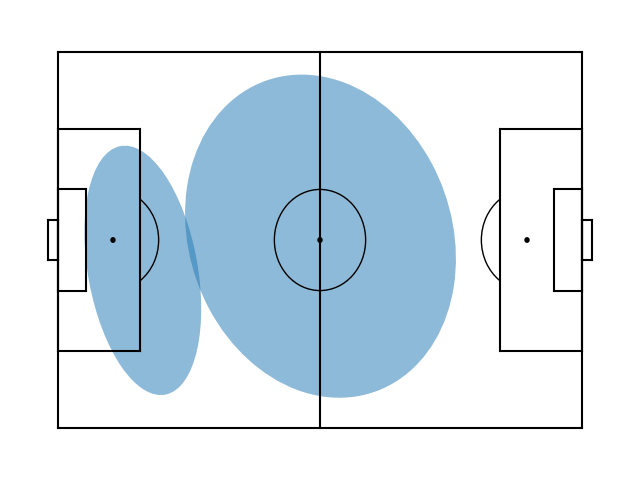

goalkick 1


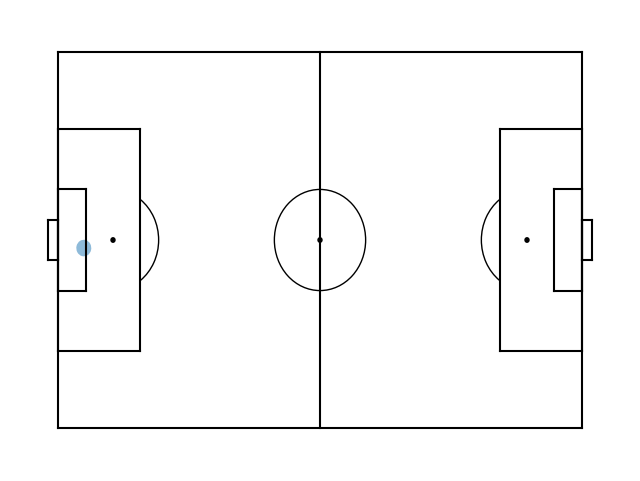

clearance 1


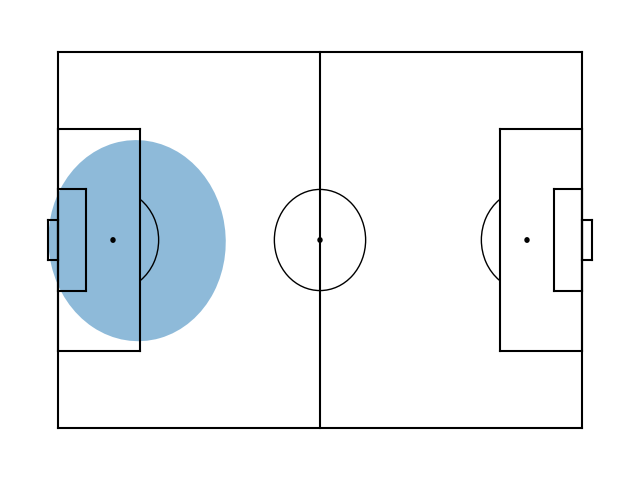

take_on 1


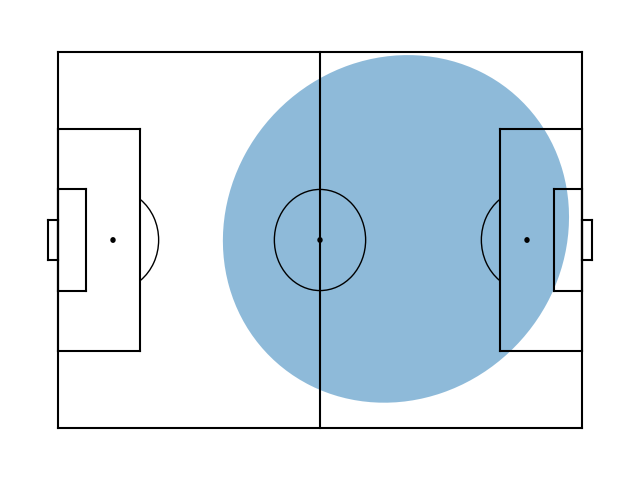

dribble 7


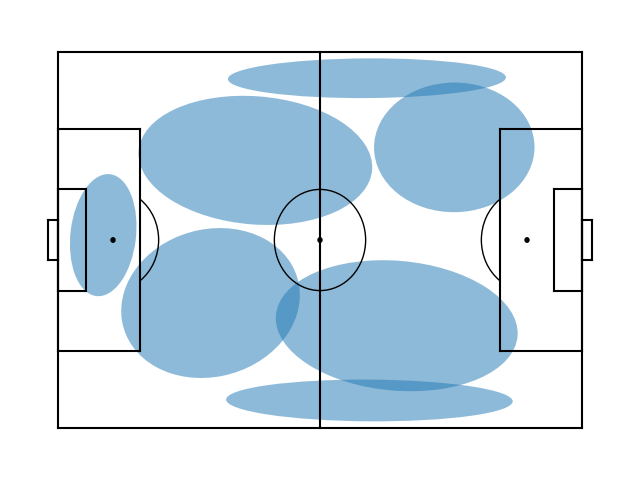

interception 2


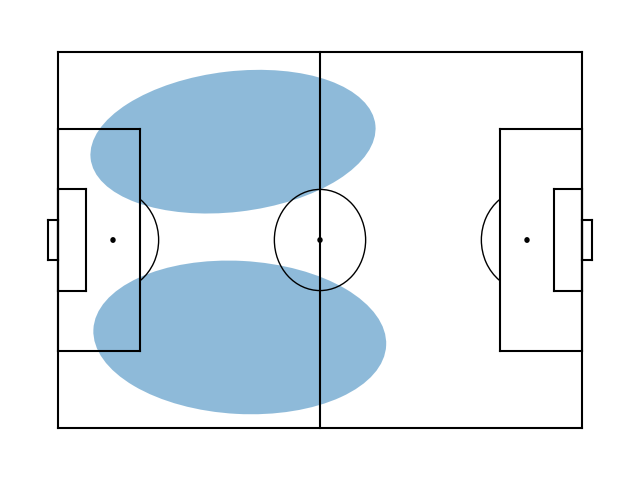

foul 1


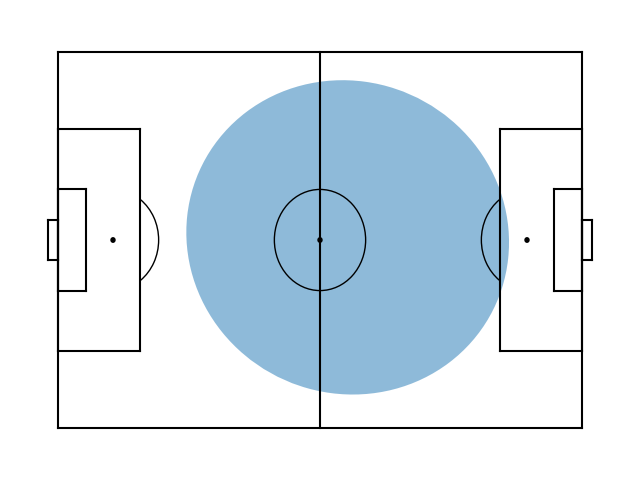

shot_penalty 1


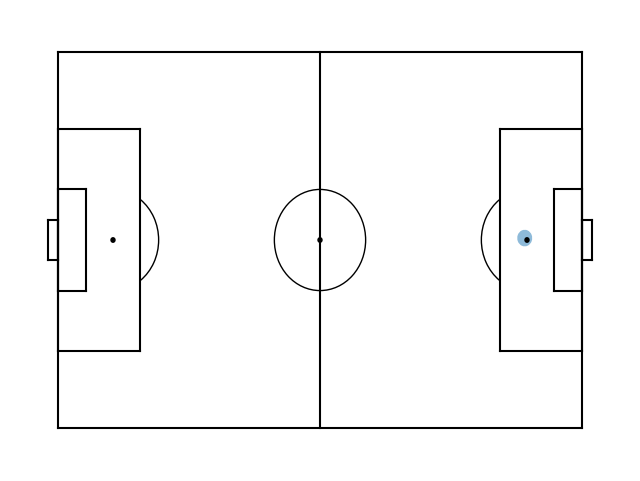

In [30]:
vis.show_all_models(loc_models,list(mix.ilp_select_models_bic_triangle(dir_candidates)))
# BIC + 추가 복잡도 패널티를 목적으로 하여 더 적은 component 선택

throw_in 2
throw_in_0 4
throw_in_1 3


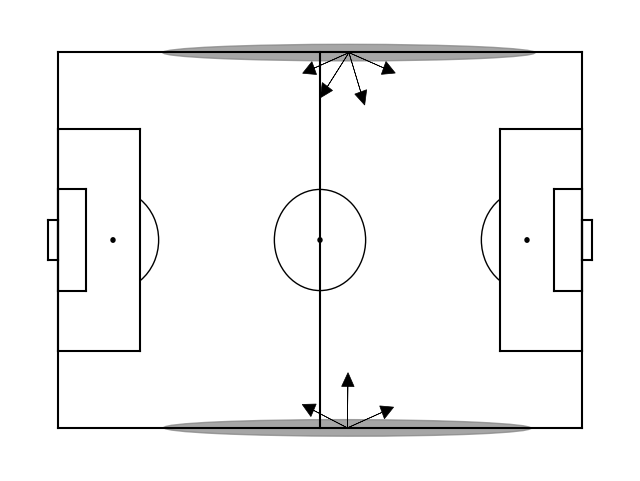

pass 7
pass_0 3
pass_1 2
pass_2 2
pass_3 3
pass_4 2
pass_5 2
pass_6 2


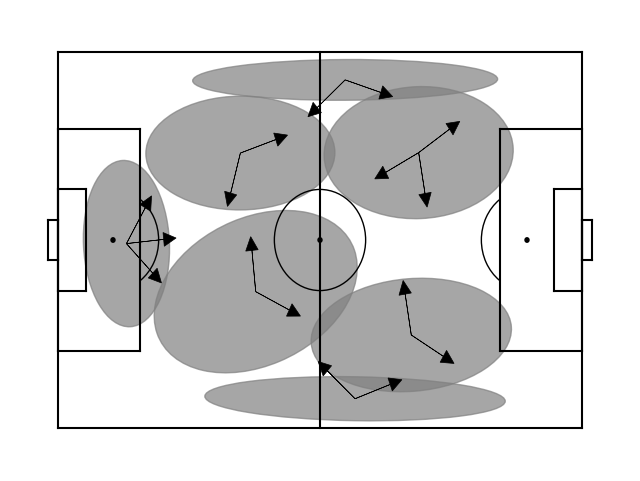

keeper_catch 6


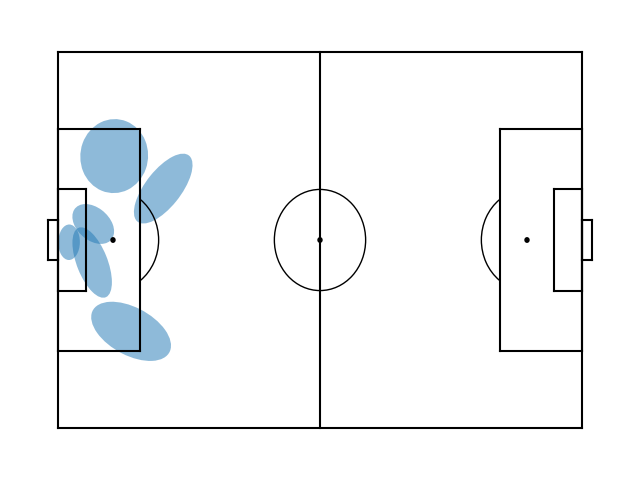

cross 2


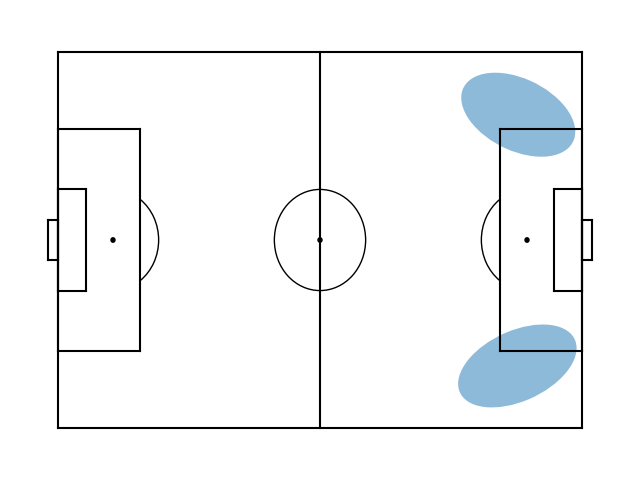

shot 1


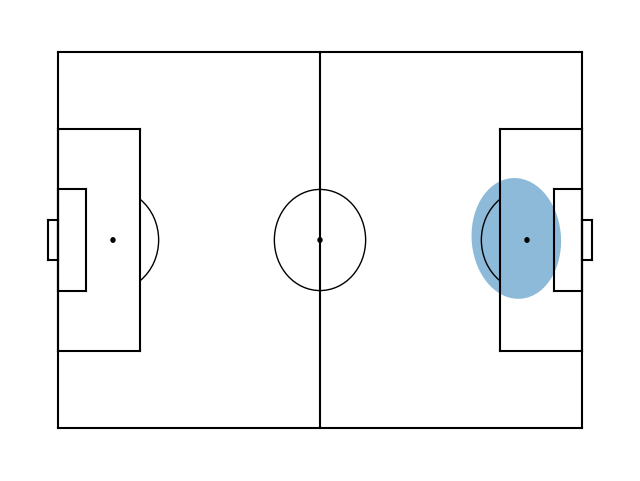

bad_touch 1


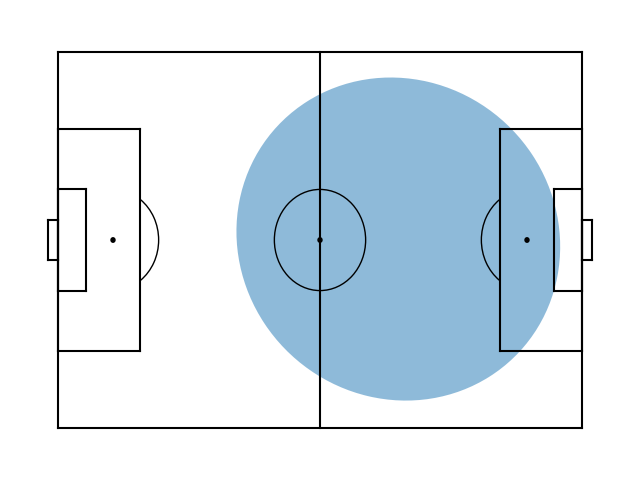

corner 2
corner_0 2
corner_1 2


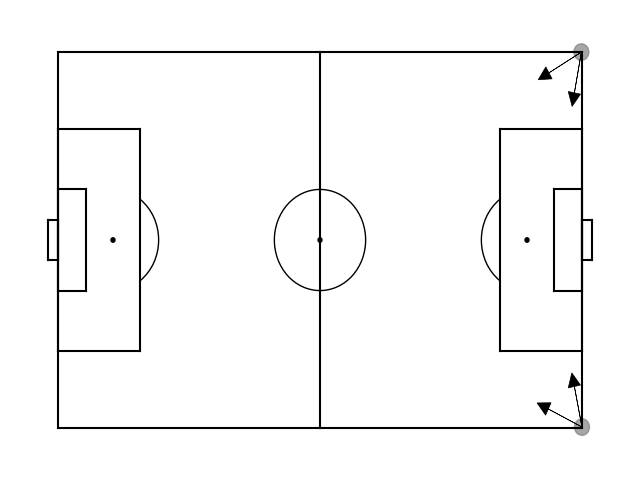

tackle 2


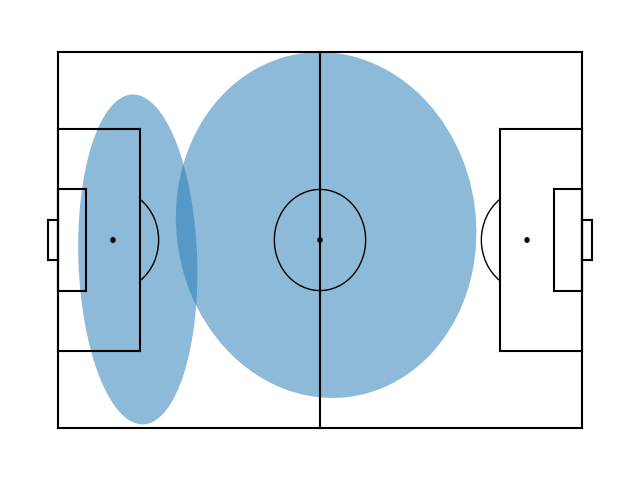

freekick 2


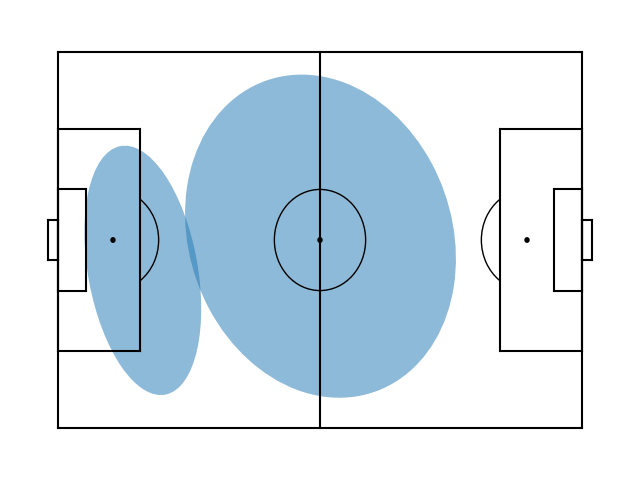

goalkick 1
goalkick_0 4


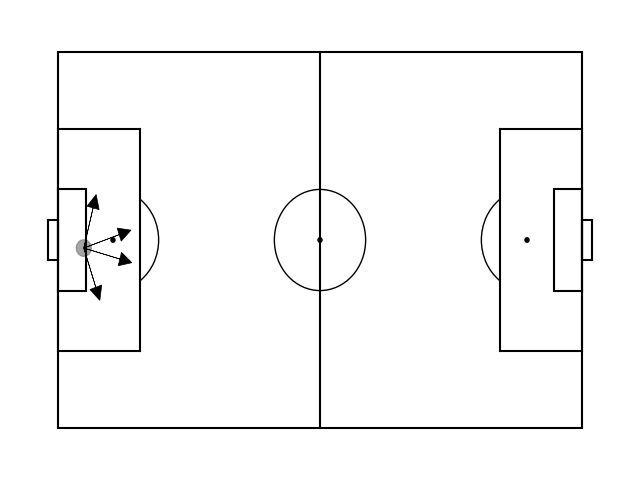

clearance 1
clearance_0 2


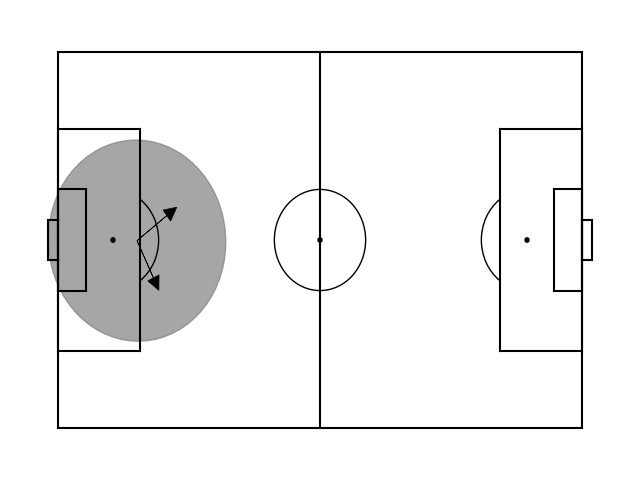

take_on 1


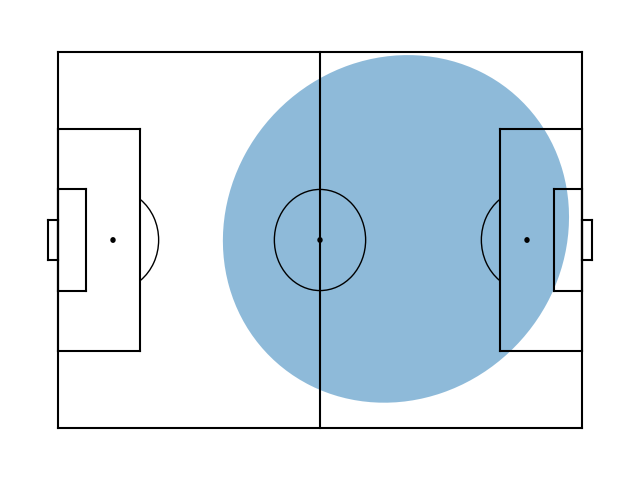

dribble 7
dribble_0 1
dribble_1 2
dribble_2 3
dribble_3 2
dribble_4 2
dribble_5 1
dribble_6 1


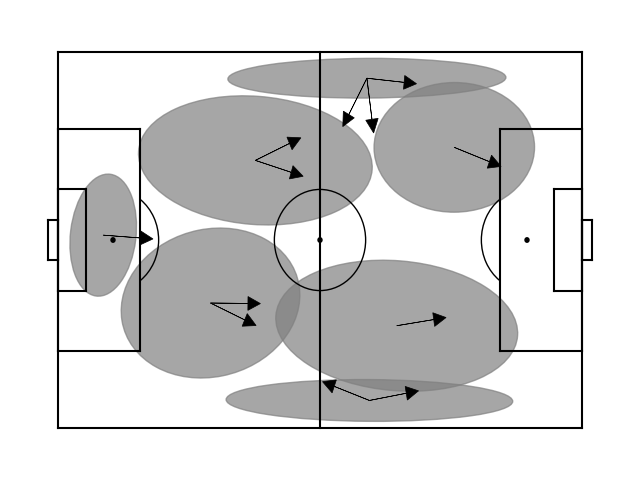

interception 2


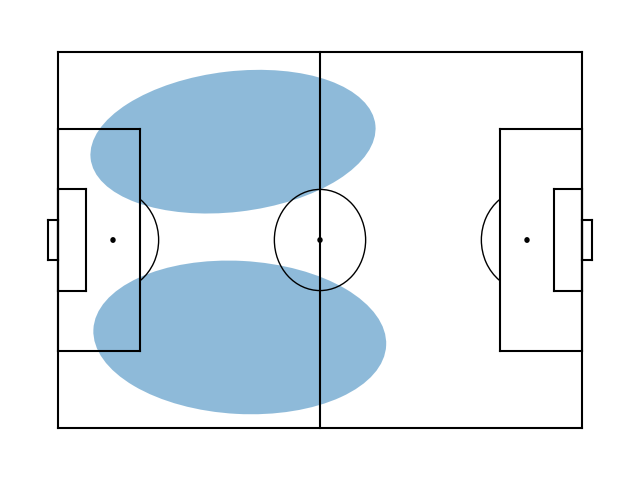

foul 1


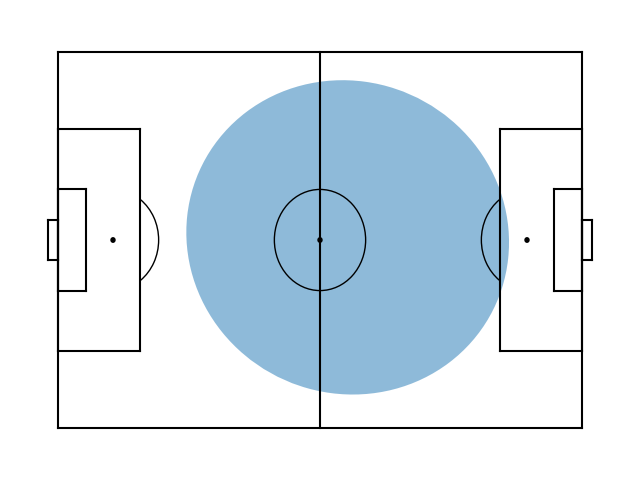

shot_penalty 1


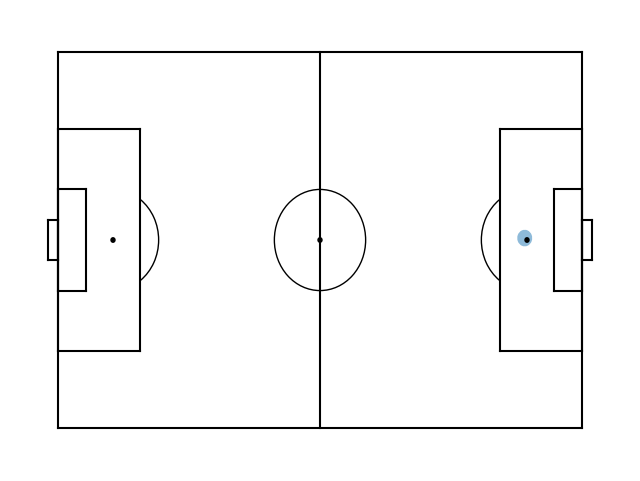

In [31]:
vis.show_all_models(loc_models, list(mix.ilp_select_models_bic(dir_candidates)))
# 파라미터 수 증가 패널티 강화

throw_in 2
throw_in_0 5
throw_in_1 4


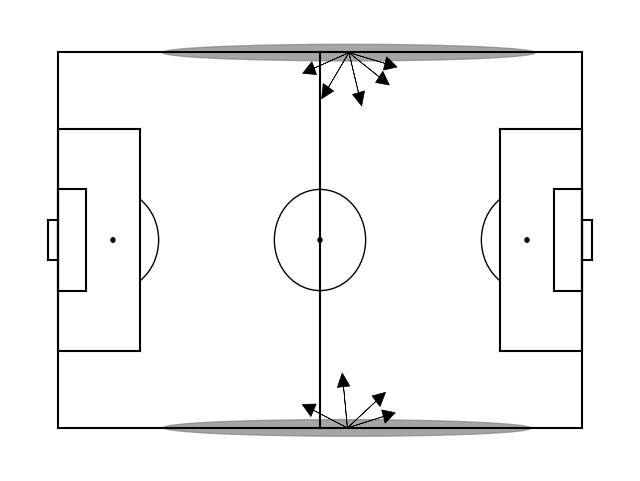

pass 7
pass_0 3
pass_1 2
pass_2 2
pass_3 3
pass_4 2
pass_5 2
pass_6 2


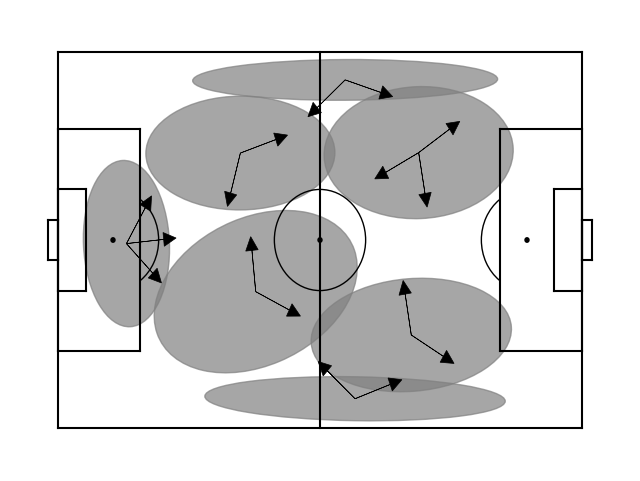

keeper_catch 6


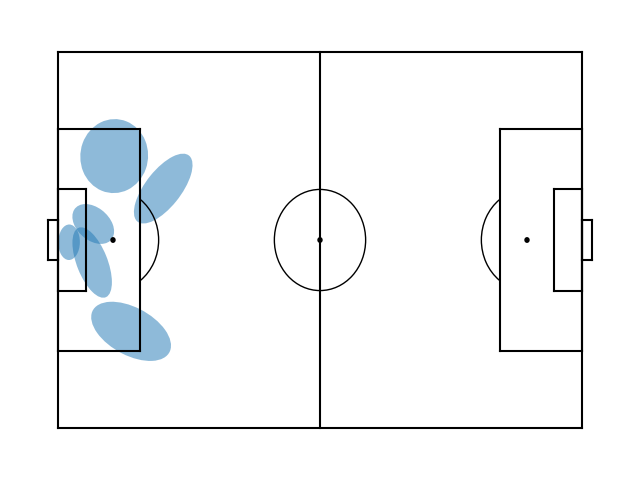

cross 2


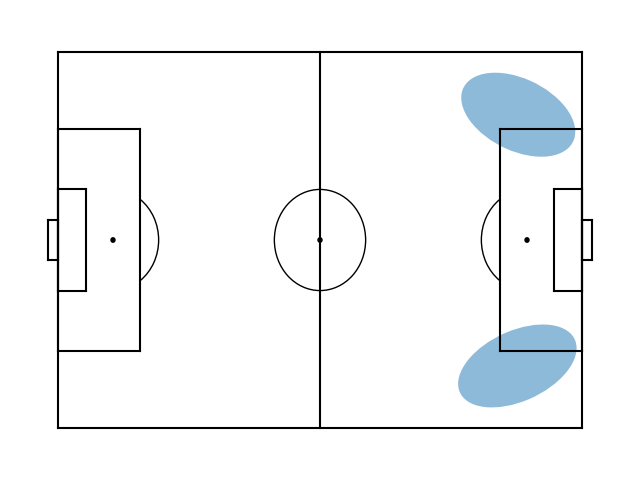

shot 1


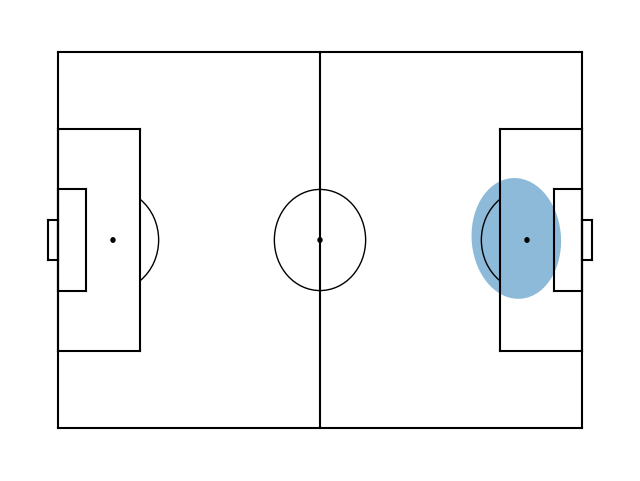

bad_touch 1


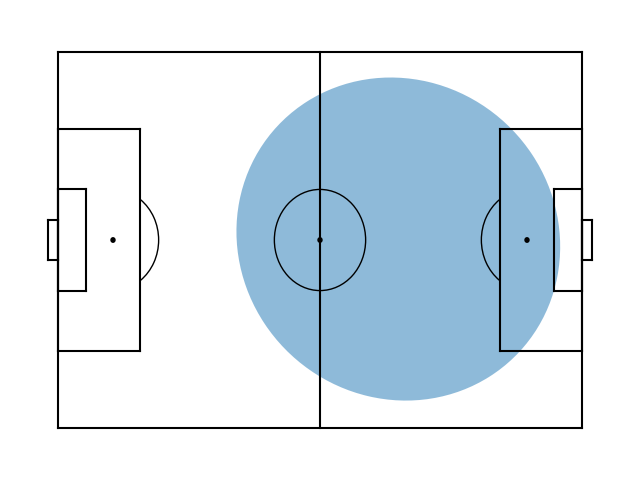

corner 2
corner_0 2
corner_1 2


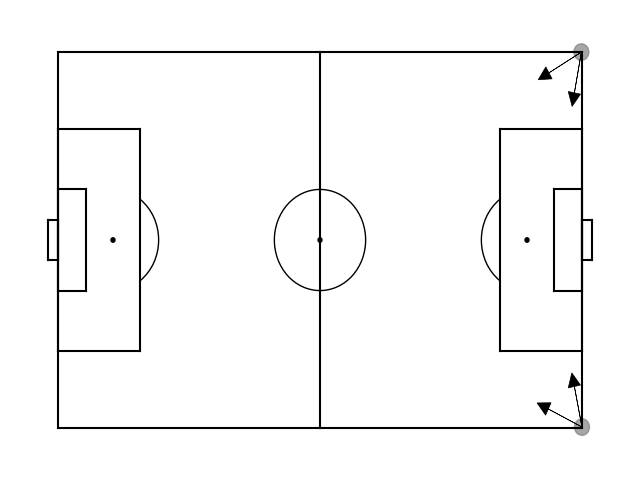

tackle 2


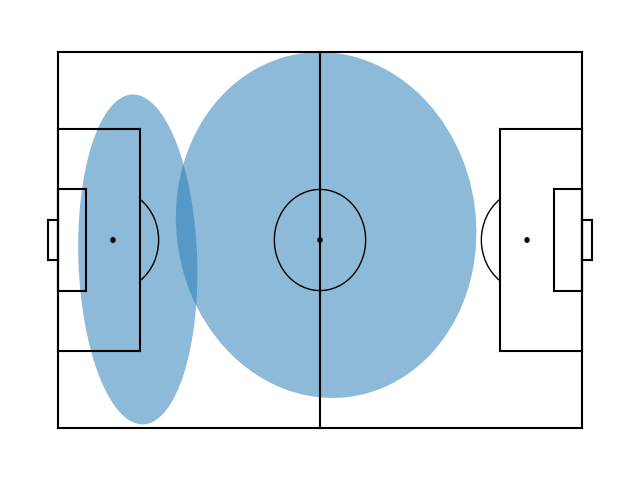

freekick 2


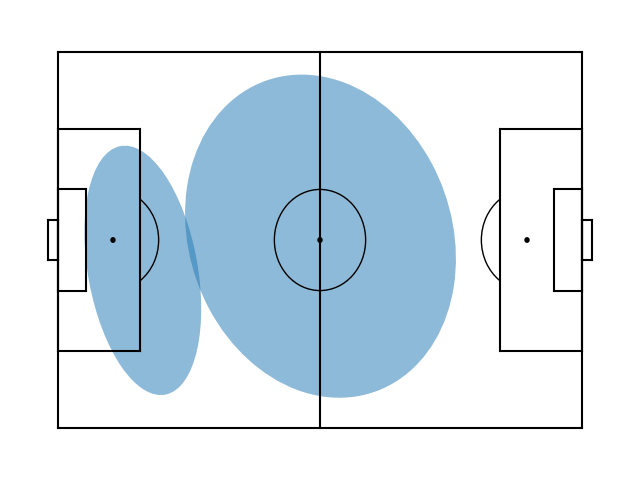

goalkick 1
goalkick_0 4


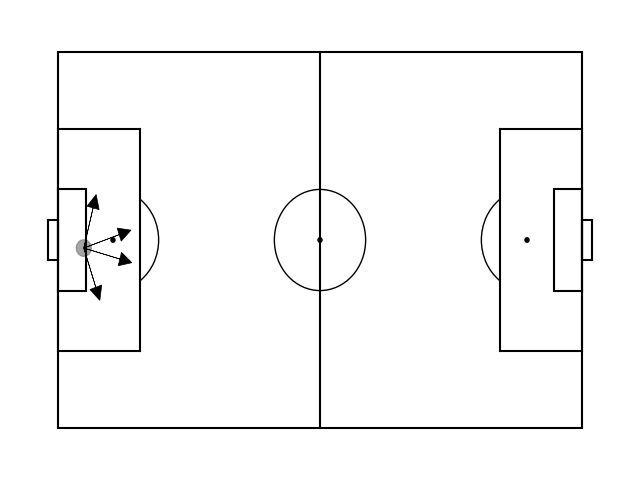

clearance 1
clearance_0 2


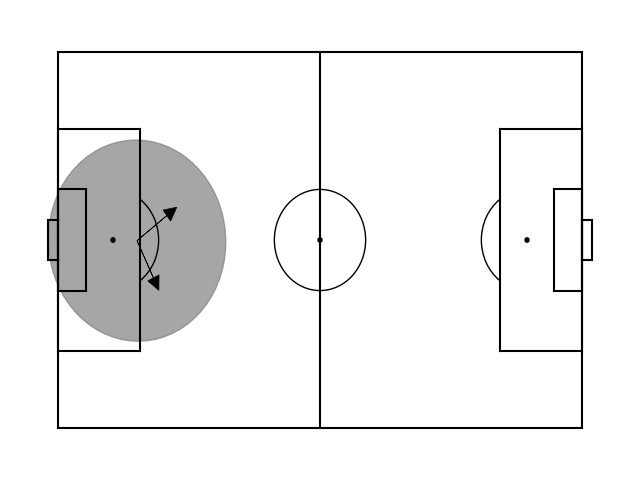

take_on 1


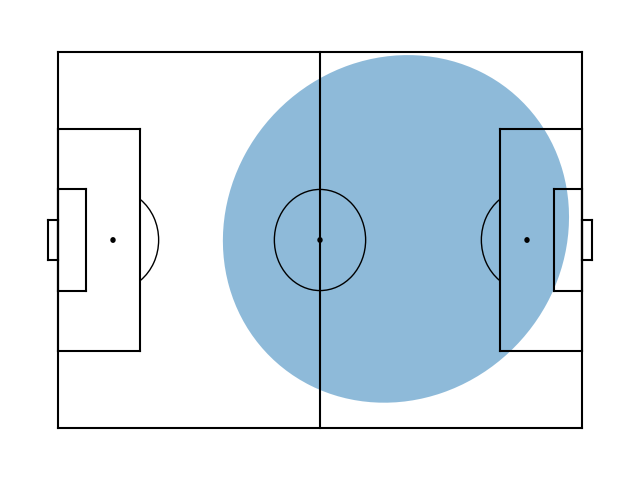

dribble 7
dribble_0 1
dribble_1 4
dribble_2 3
dribble_3 2
dribble_4 2
dribble_5 1
dribble_6 1


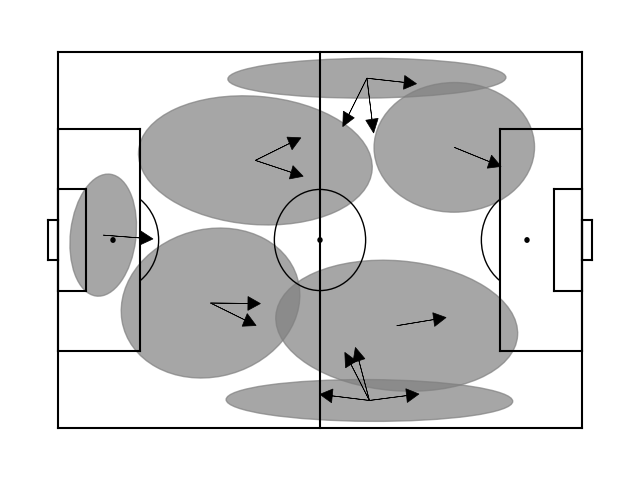

interception 2


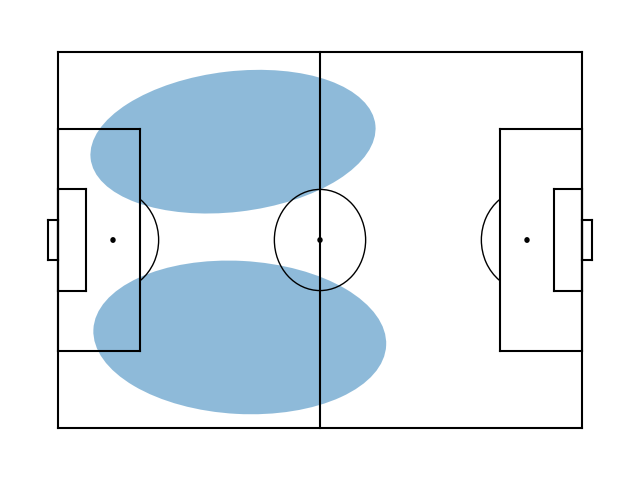

foul 1


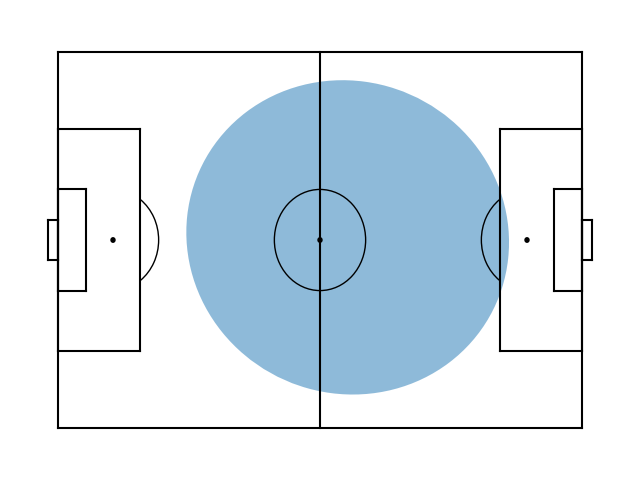

shot_penalty 1
shot_penalty_0 2


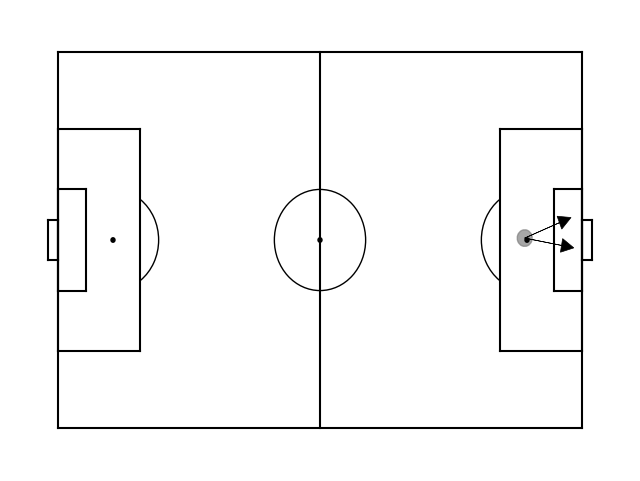

In [32]:
vis.show_all_models(loc_models,list(mix.select_models_solo_bic(dir_candidates)))

## Optimize # directions

In [33]:
for m in dir_candidates:
    m.solo_bic = np.log(m.weight_total) * m._n_parameters() - 2*m.loglikelihood
    print(m.name, m.n_components, m.solo_bic)

throw_in_0 1 1527.0082904810868
throw_in_0 2 1301.2022700679313
throw_in_0 3 1203.82249045572
throw_in_0 4 1193.3349215801964
throw_in_0 5 1193.11832600045
throw_in_0 6 1205.222190251063
throw_in_0 7 1215.4677498622739
throw_in_0 8 1224.3237772880636
throw_in_0 9 1236.323608848524
throw_in_1 1 1642.736133387598
throw_in_1 2 1408.445944828079
throw_in_1 3 1325.9891346456109
throw_in_1 4 1320.340649975413
throw_in_1 5 1323.6499482795969
throw_in_1 6 1333.559670535674
throw_in_1 7 1343.3104717237736
throw_in_1 8 1352.2252012740576
throw_in_1 9 1364.4208229553421
pass_0 1 11313.654375113732
pass_0 2 11249.452914397363
pass_0 3 11243.632486425447
pass_0 4 11251.38463343984
pass_0 5 11264.575461425586
pass_0 6 11286.067351352553
pass_0 7 11290.647026049099
pass_0 8 11317.807296449924
pass_0 9 11392.5210624323
pass_1 1 8191.074818104244
pass_1 2 7870.914685838399
pass_1 3 7903.0370676998555
pass_1 4 7924.196593114382
pass_1 5 7906.8895320809415
pass_1 6 7938.142436521167
pass_1 7 7956.1455878

throw_in 0
5


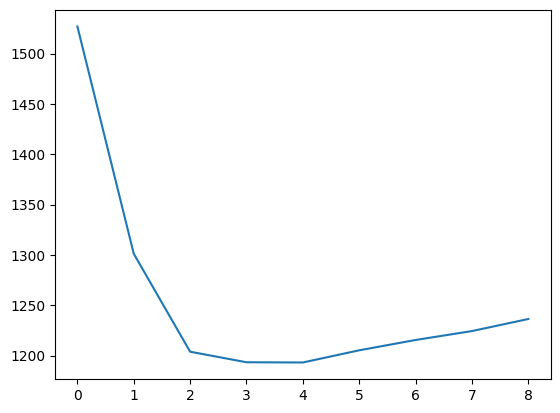

throw_in 1
4


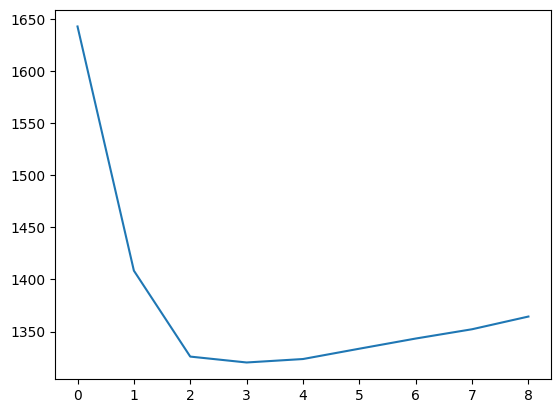

pass 0
3


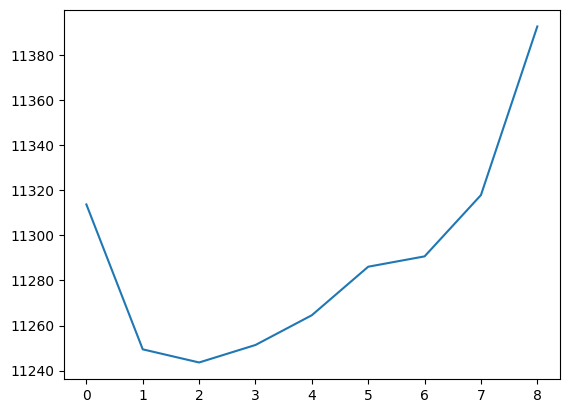

pass 1
2


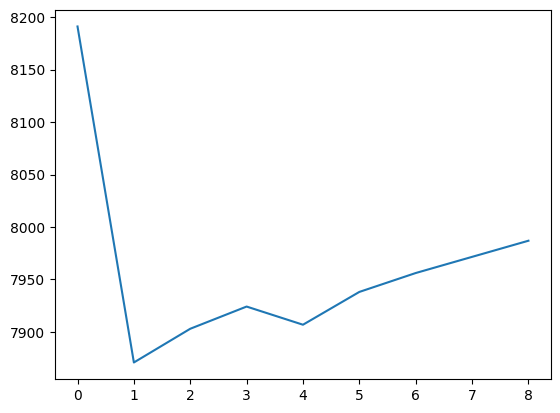

pass 2
2


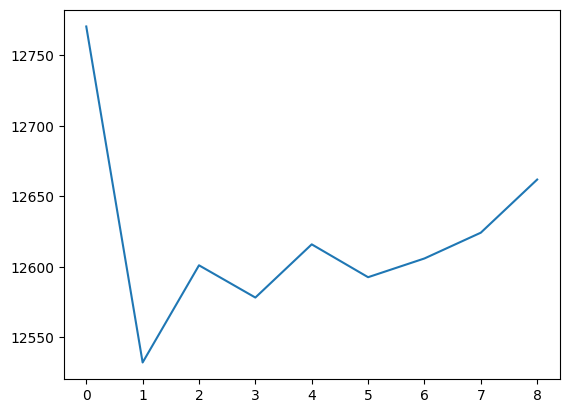

pass 3
3


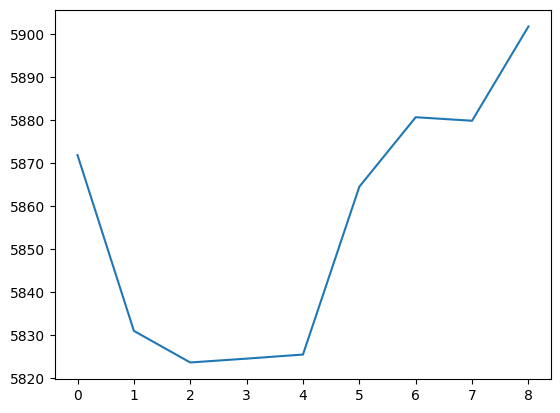

pass 4
2


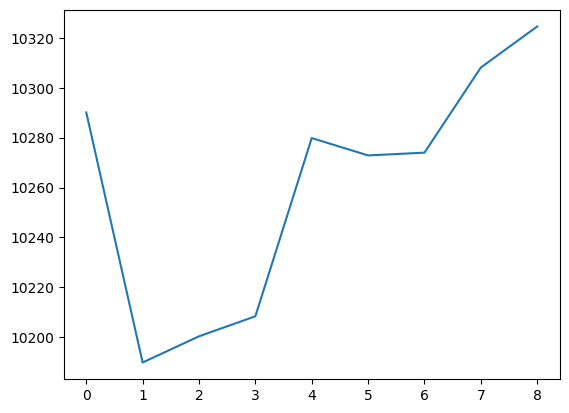

pass 5
2


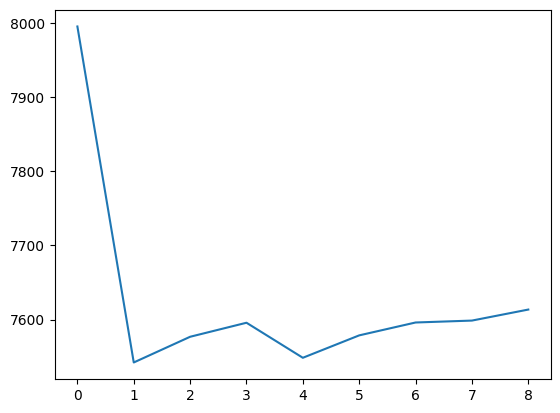

pass 6
2


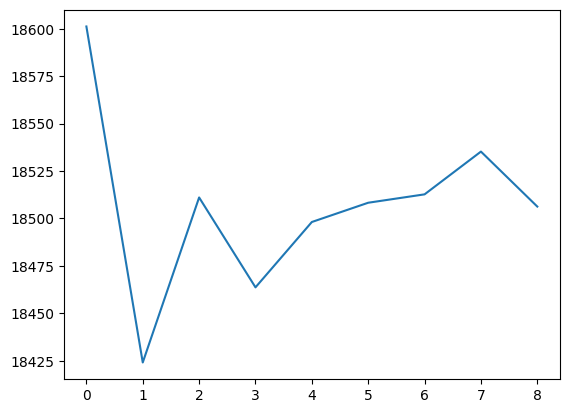

keeper_catch 0
1


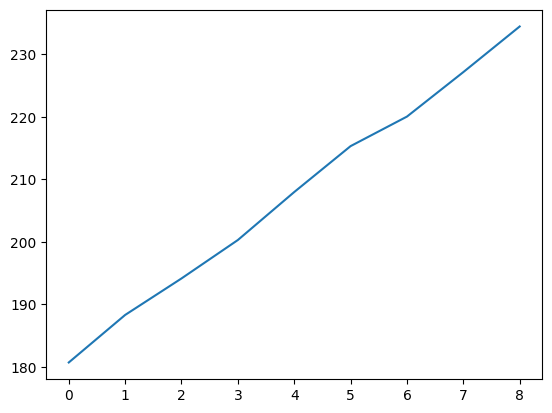

keeper_catch 1
1


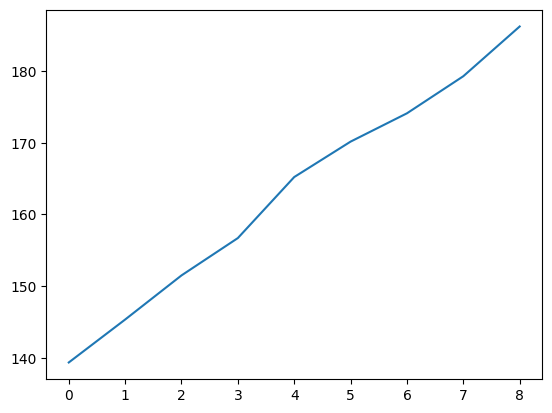

keeper_catch 2
1


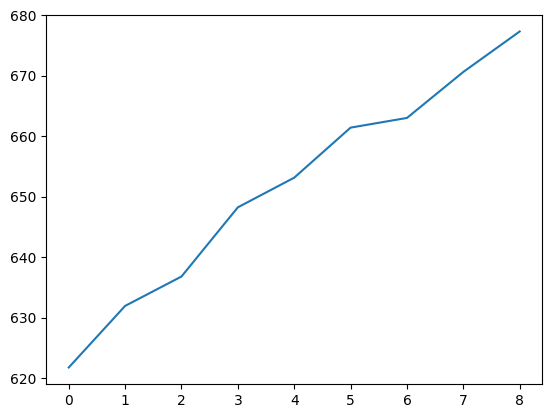

keeper_catch 3
1


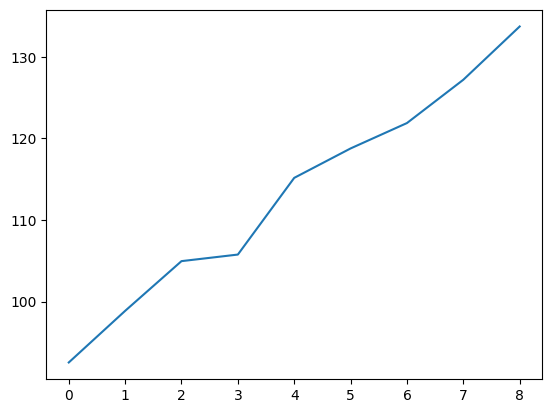

keeper_catch 4
1


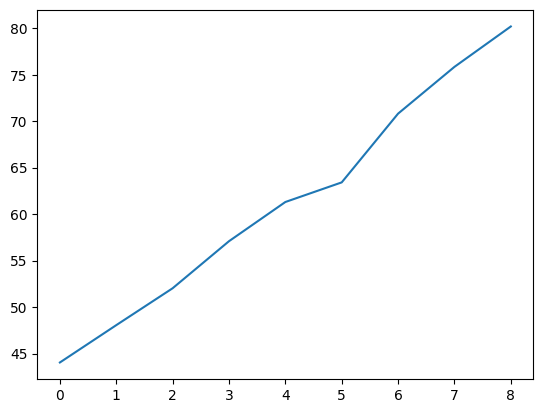

keeper_catch 5
1


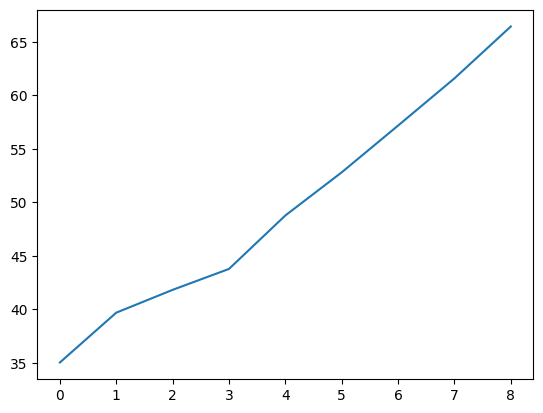

cross 0
1


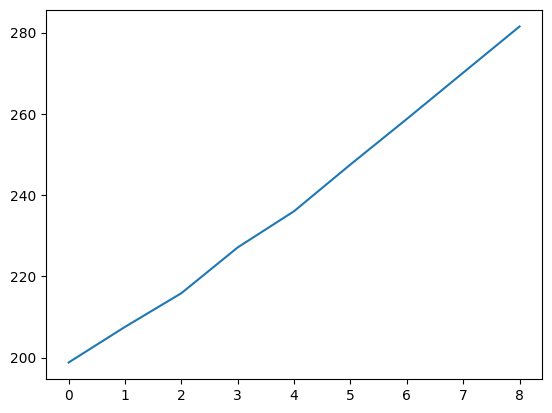

cross 1
1


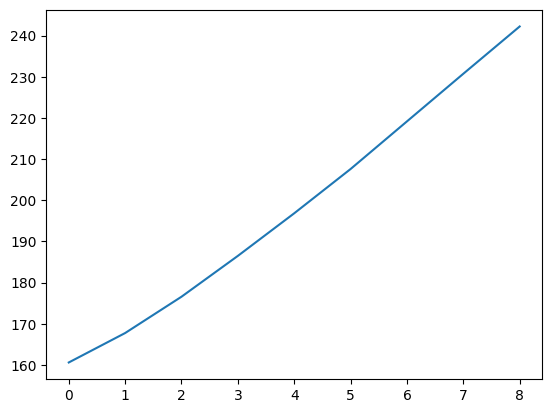

shot 0
1


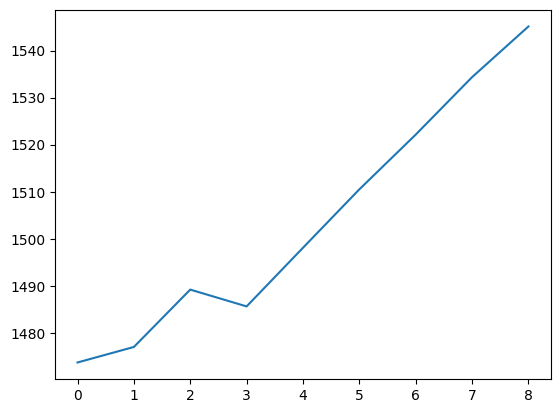

bad_touch 0
1


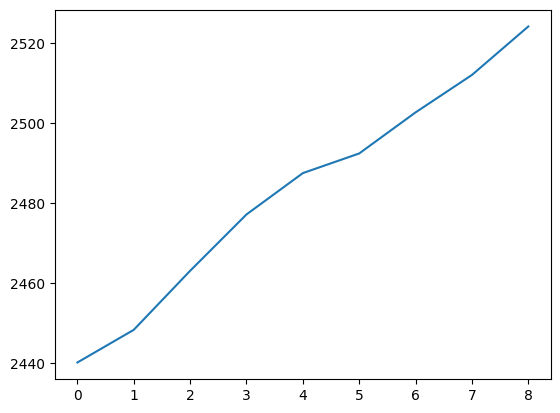

corner 0
2


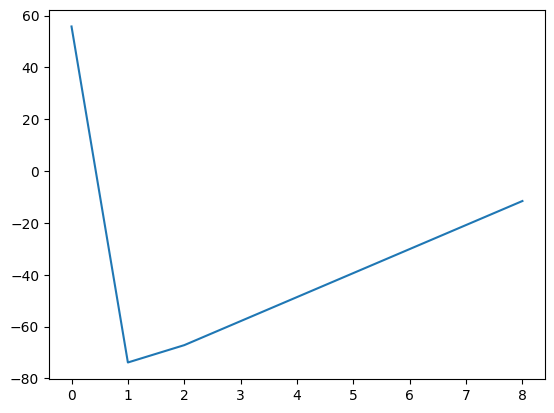

corner 1
2


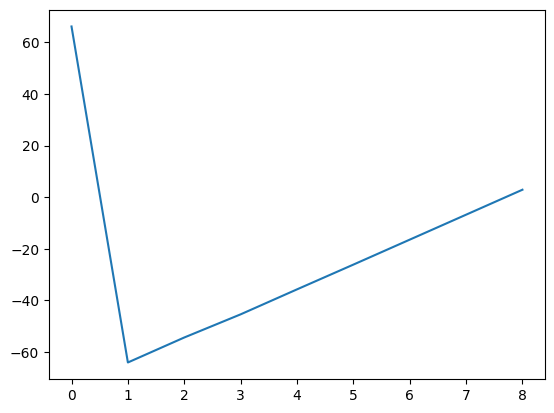

tackle 0
1


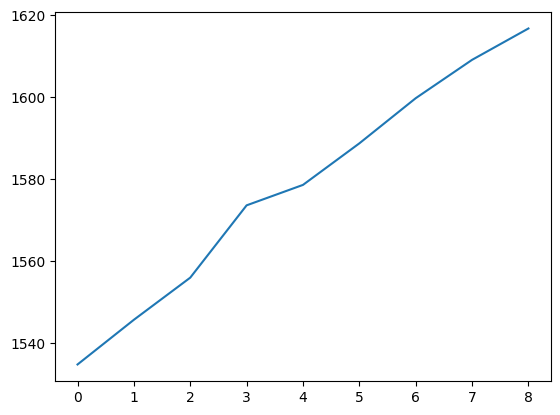

tackle 1
1


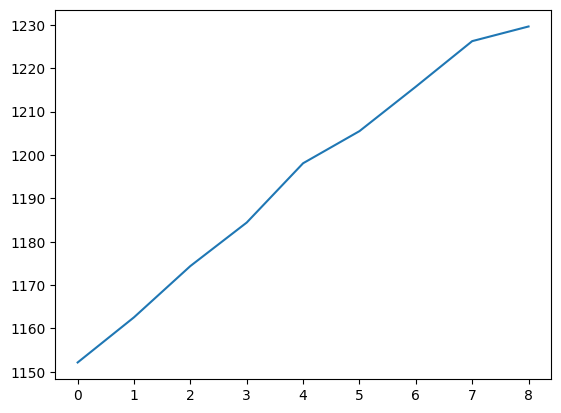

freekick 0
1


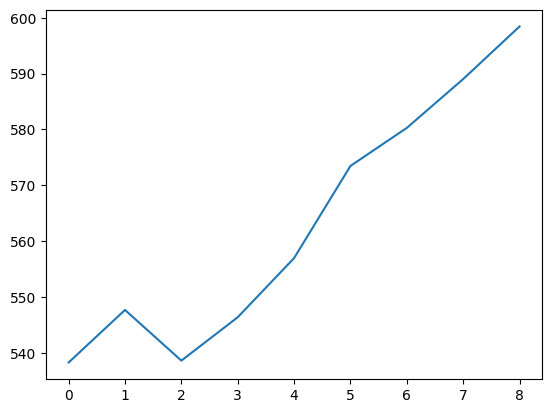

freekick 1
1


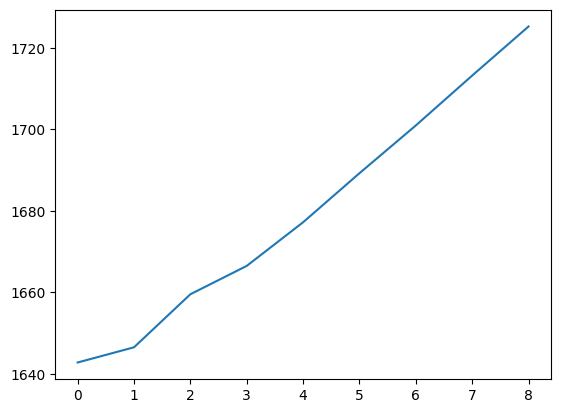

goalkick 0
4


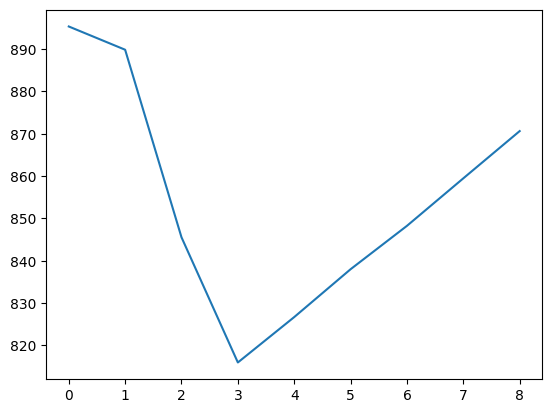

clearance 0
2


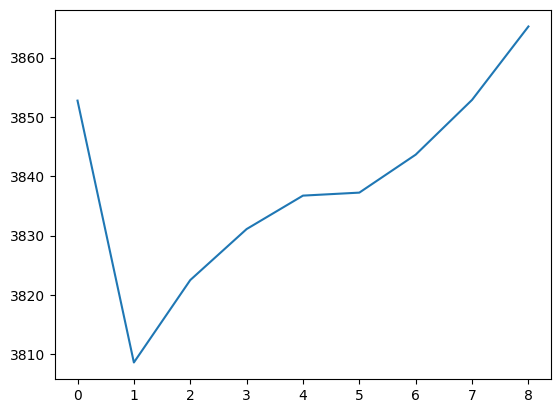

take_on 0
1


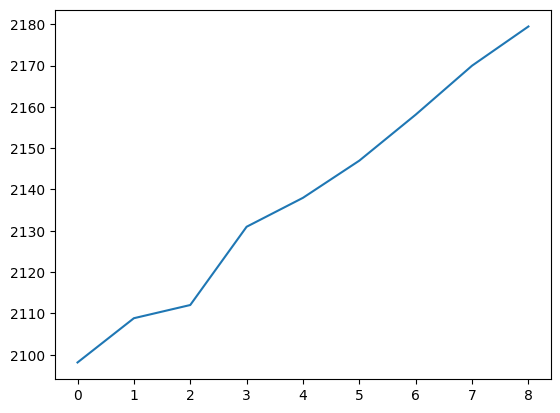

dribble 0
1


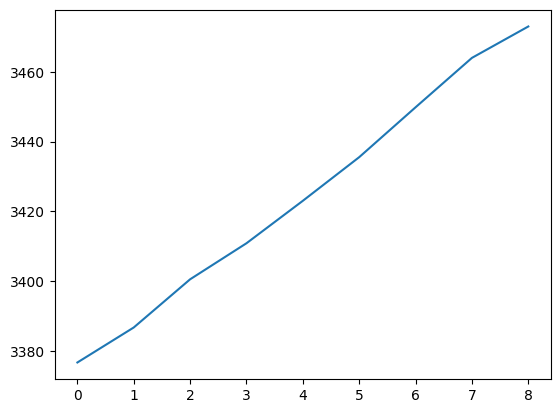

dribble 1
4


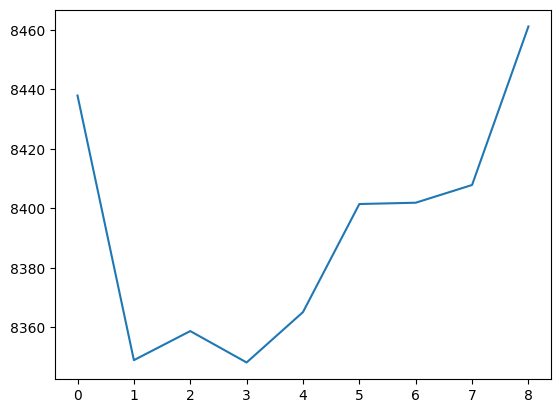

dribble 2
3


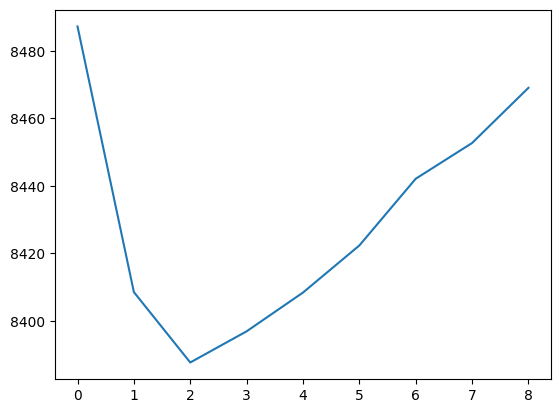

dribble 3
2


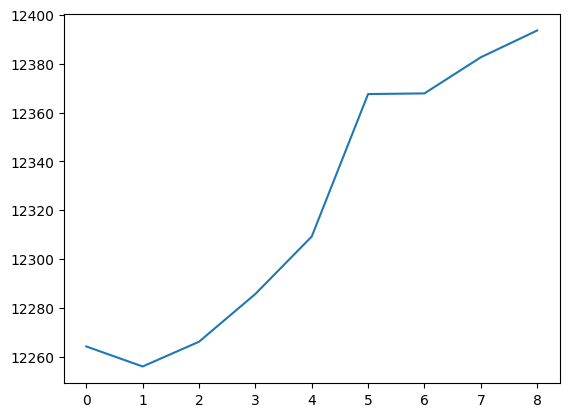

dribble 4
2


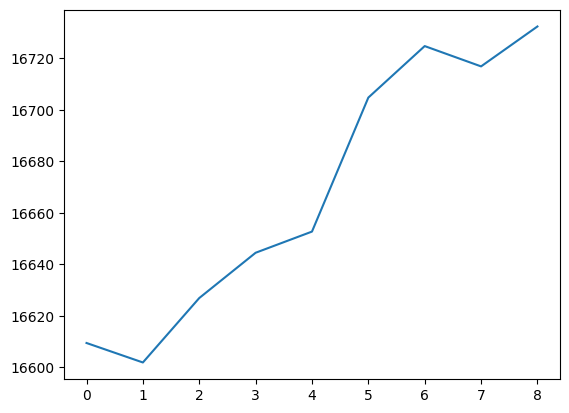

dribble 5
1


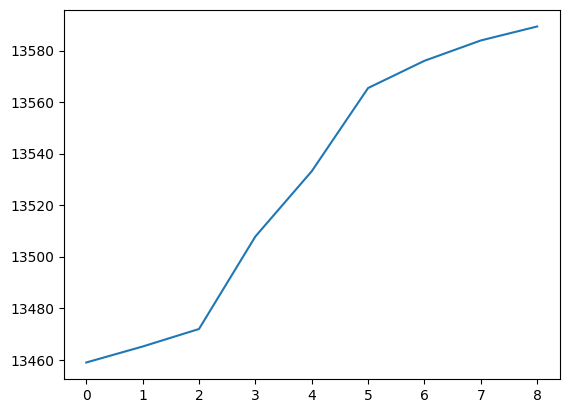

dribble 6
1


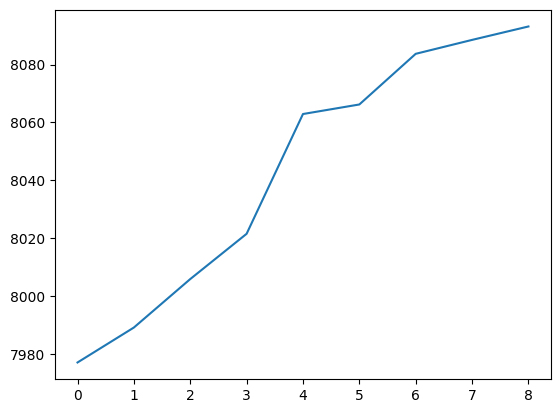

interception 0
1


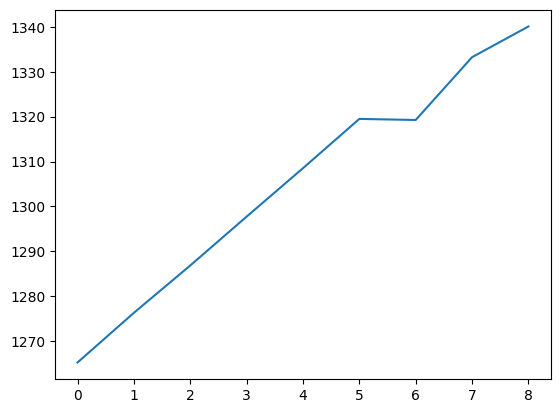

interception 1
1


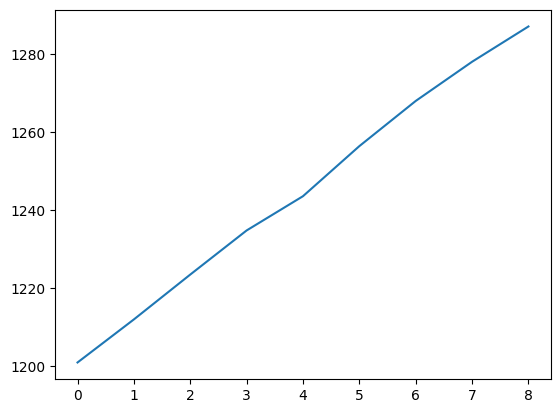

foul 0
1


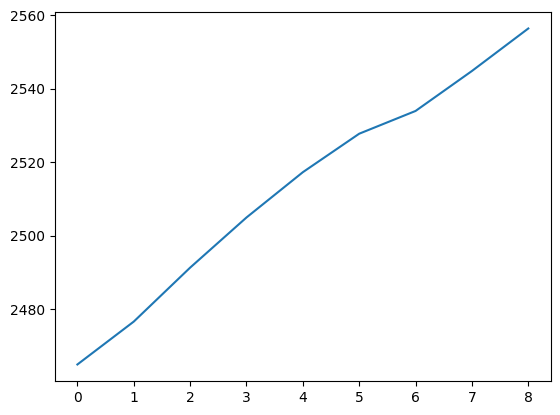

shot_penalty 0
2


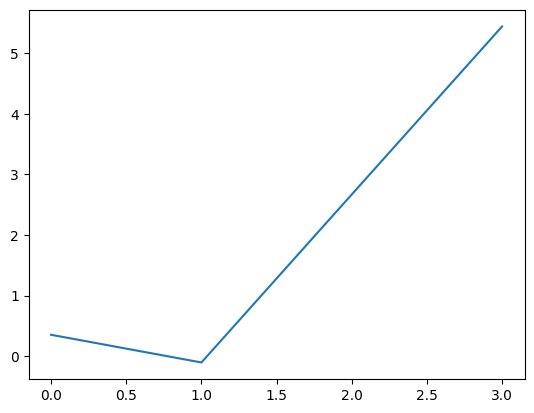

In [34]:
for l in loc_models:
    for i, gauss in enumerate(l.submodels):
        bic_scores = []
        for  m in dir_candidates:
            if f"{l.name}_{i}" == m.name:
                bic_scores.append(m.solo_bic)
            
        print(l.name, i)
        print(np.argmin(bic_scores)+1)
        plt.figure()
        plt.plot(range(0,len(bic_scores)), bic_scores)
        plt.show()

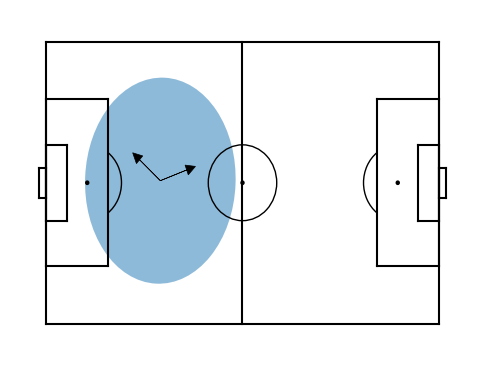

In [35]:

# 특정 이벤트의 방향 분포 모델을 시각화하는 코드
name = "pass"
loc_comp = 2   # 위치 클러스터 수
nb = 1         # 위치 클러스터 index
n_dir_comp = 2 # 방향 클러스터 수

# loc 모델 중에서: pass 이고, 클러스터 수=2 인 모델 선택 + 그중 1번 cluster 골라내기
for m in loc_candidates:
    if ((m.name == name) & (m.n_components == loc_comp)):
        for i, g in enumerate(m.submodels):
            if (i == nb):
                gauss = g    # 선택된 위치 Gaussian 모델 (특정 cluster)
                model = m    # 해당 액션 전체 모델
                break
        else:
            continue
        break

# dir 모델들 중: 위에서 선택한 cluster에 대응하고, n_dir_comp=2 인 모델 선택
for n in dir_candidates:
    if f"{model.name}_{nb}" == n.name:
        if len(n.submodels) == n_dir_comp:
            dirmod = n
            break

# 위치 + 방향 함께 시각화
vis.show_direction_model(gauss, dirmod)


## Make selection

In [36]:
# 이벤트 타입별 최종 방향모형 선택 리스트
# (각 loc cluster마다 방향분포 수를 지정)
dir_selection = [
    ("offside_0", 1),
    ("goal_0" , 1),
    ("red_card_0" , 1),
    ("shot_0", 1),
    ("goalkick_0" , 1),
    ("corner_0", 1),
    ("corner_1", 1),
    ("cross_0" , 1),
    ("cross_1" , 1),
    ("shot_penalty_0", 1),
    ("freekick_0", 1),
    ("freekick_1", 1),
    ("owngoal_0", 1),
    ("clearance_0", 1)
]
# 클러스터 별  방향 개수 다르게
dir_selection.extend([(f"receival_{nb}", 1) for nb in range(0,6)])
catch = [3,2,1,1,2]
dir_selection.extend([(f"keeper_catch_{nb}", catch[nb]) for nb in range(0,5)])
dir_selection.extend([(f"foul_{nb}", 1) for nb in range(0,1)])
                      
dribbles = [1,1,1,2,3,2,1]
dir_selection.extend([(f"dribble_{nb}", dribbles[nb]) for nb in range(0,7)])
                      
passes = [4,1,2,2]
dir_selection.extend([(f"pass_{nb}", passes[nb]) for nb in range(0,4)])   

dir_selection.extend([(f"bad_touch_{nb}", 1) for nb in range(0,1)])
dir_selection.extend([(f"take_on_{nb}", 1) for nb in range(0,1)])
dir_selection.extend([(f"tackle_{nb}", 1) for nb in range(0,2)])

throw = [1,2]
dir_selection.extend([(f"throw_in_{nb}", throw[nb]) for nb in range(0,2)]) 

dir_selection.extend([(f"out_{nb}", 1) for nb in range(0,4)])
dir_selection.extend([(f"interception_{nb}", 1) for nb in range(0,2)])
dir_selection.extend([(f"yellow_card_{nb}", 1) for nb in range(0,3)])

In [37]:
dir_models = []
for n in dir_candidates:
    if ((n.name, n.n_components) in dir_selection):
        dir_models.append(n)

throw_in 2
throw_in_0 1
throw_in_1 2


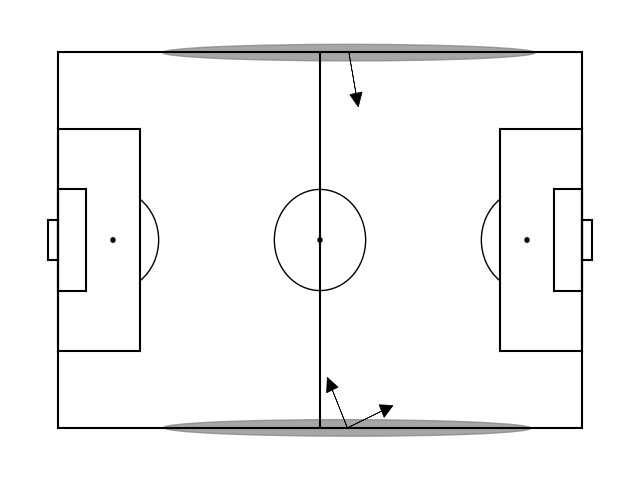

pass 7
pass_0 4
pass_1 1
pass_2 2
pass_3 2


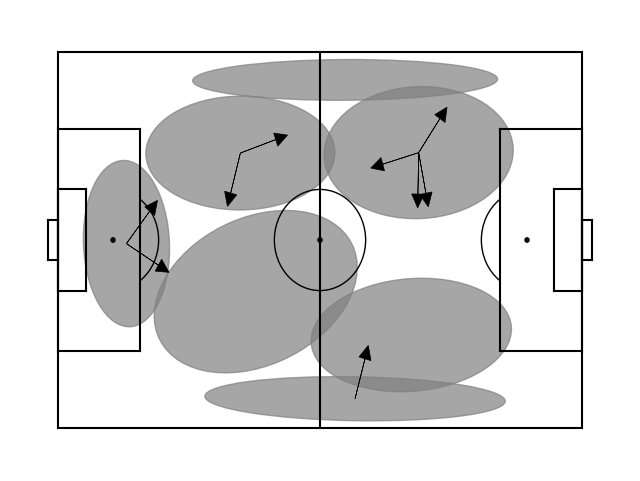

keeper_catch 6
keeper_catch_0 3
keeper_catch_1 2
keeper_catch_2 1
keeper_catch_3 1
keeper_catch_4 2


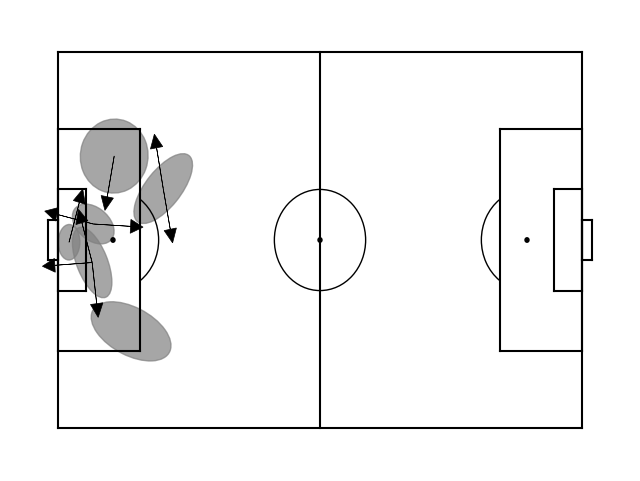

cross 2


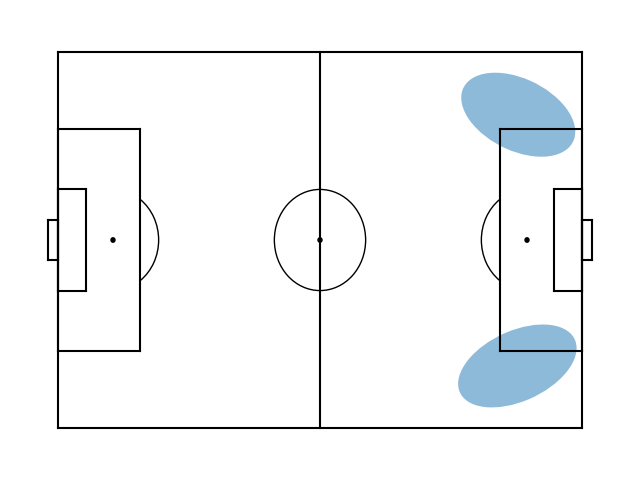

shot 1


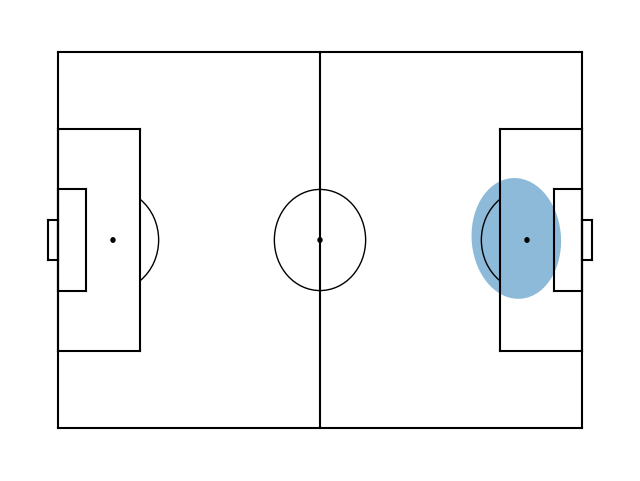

bad_touch 1


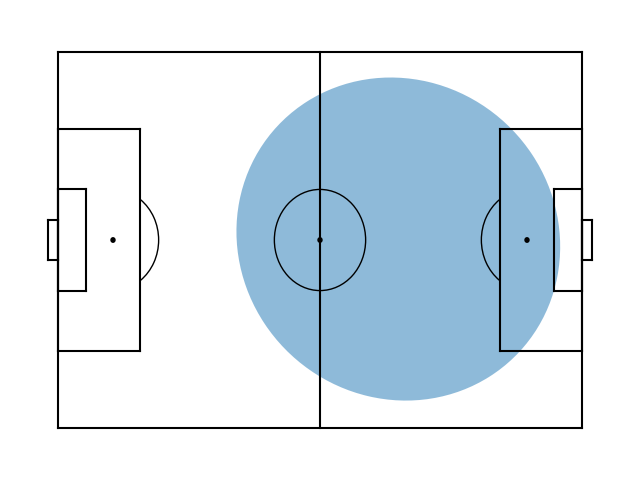

corner 2


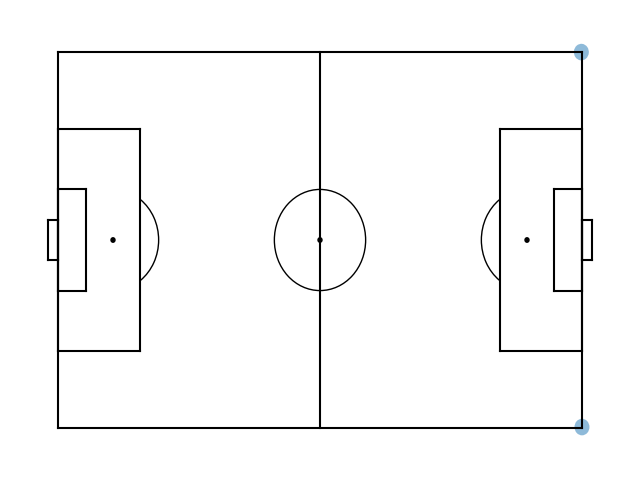

tackle 2


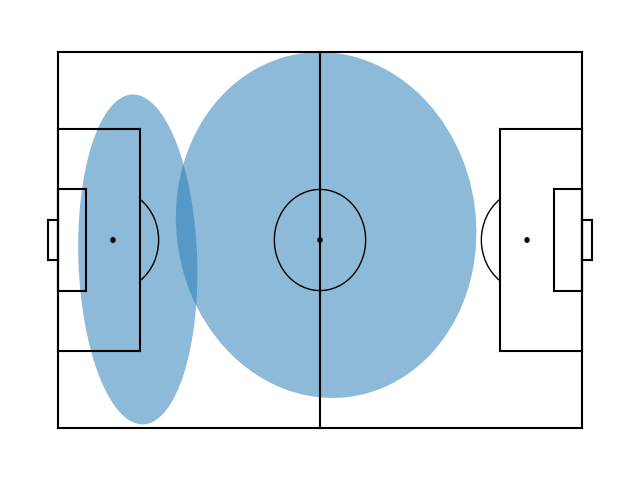

freekick 2


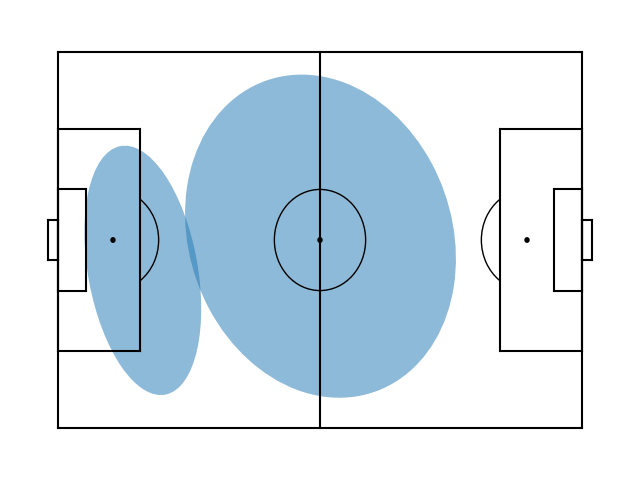

goalkick 1


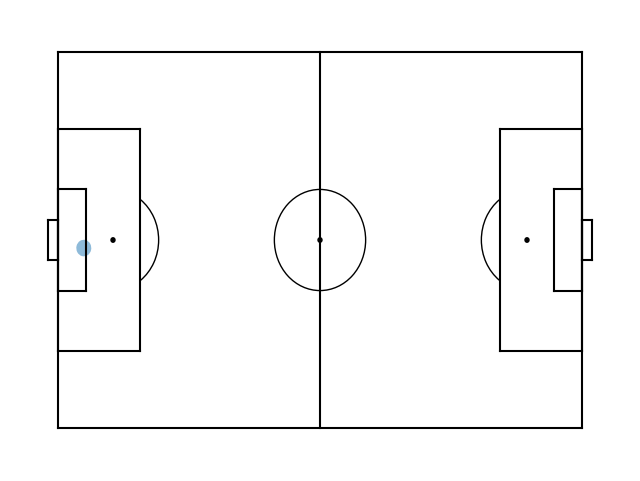

clearance 1


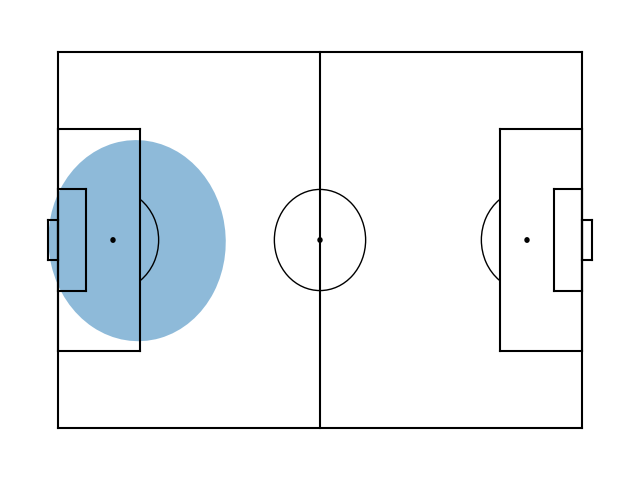

take_on 1


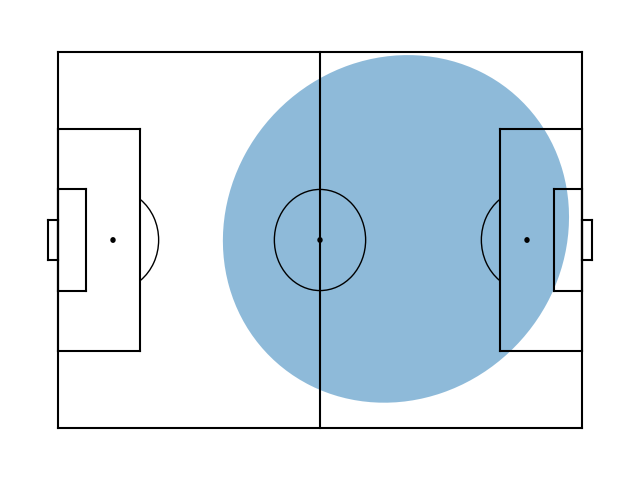

dribble 7
dribble_0 1
dribble_1 1
dribble_2 1
dribble_3 2
dribble_4 3
dribble_5 2
dribble_6 1


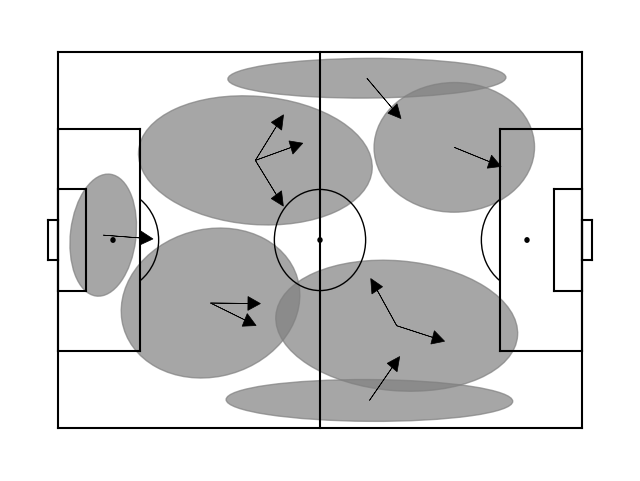

interception 2


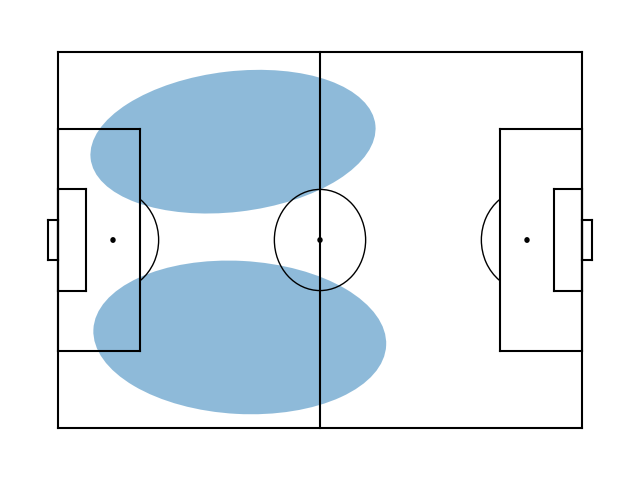

foul 1


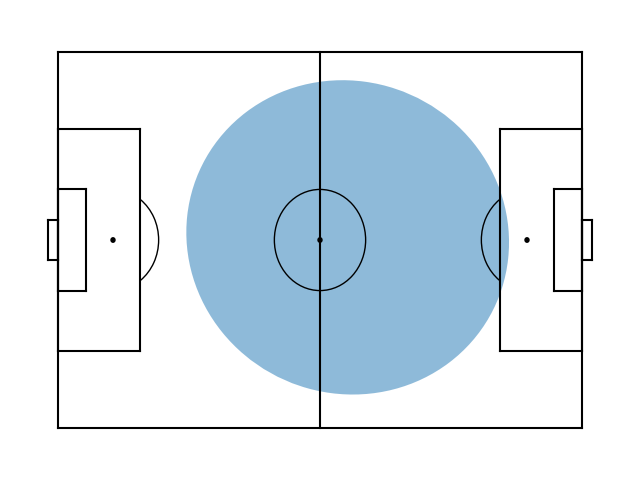

shot_penalty 1


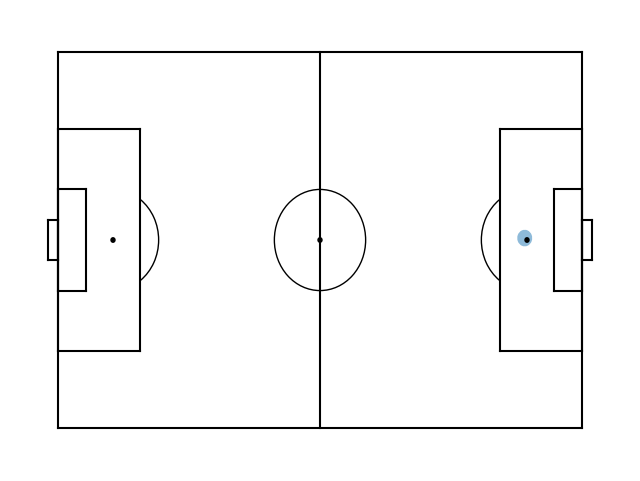

In [38]:
vis.show_all_models(loc_models,dir_models)

In [39]:
dir_weights = mix.probabilities(dir_models, a[["mov_angle_a0"]], loc_weights)

## Save direction models

In [40]:
with open('../data/soccermix_J1_models.pkl','ab') as wfp:
    pickle.dump(dir_models, wfp)

In [41]:
data3 = open('../data/soccermix_J1_dirweights.pkl', 'wb') 

s_dir_weights = dir_weights.astype(pd.SparseDtype("float", 0.0))
s_dir_weights.to_pickle(data3)

data3.close()

## Get final weights for full dataset

In [53]:
all_actions = simplify(final_df)
all_actions = pd.concat([all_actions,fs.movement_polar(all_actions)],axis=1) # add polar movement direction

In [54]:
all_cat_weights = cat_model.predict_proba(all_actions["type_name"])
X = all_actions[["x","y"]]
cat_weights = remove_outliers(X,all_cat_weights)

# 각 이벤트가 각 위치 클러스터에 속할 확률 계산
all_loc_weights = mix.probabilities(loc_models,all_actions[["x","y"]],all_cat_weights)
# 각 이벤트가 각 방향 분포 확률 계산
all_dir_weights = mix.probabilities(dir_models, all_actions[["mov_angle_a0"]], all_loc_weights)

In [44]:
data1 = open('../data/soccermix_J1_all_catweights.pkl', 'wb') 

s_cat_weights = all_cat_weights.astype(pd.SparseDtype("float", 0.0))
s_cat_weights.to_pickle(data1)

data1.close()

In [45]:
data2 = open('../data/soccermix_J1_all_locweights.pkl', 'wb') 

s_loc_weights = all_loc_weights.astype(pd.SparseDtype("float", 0.0))
s_loc_weights.to_pickle(data2)

data2.close()

In [46]:
data3 = open('../data/soccermix_J1_all_dirweights.pkl', 'wb') 

s_dir_weights = all_dir_weights.astype(pd.SparseDtype("float", 0.0))
s_dir_weights.to_pickle(data3)

data3.close()

In [47]:
for col in all_actions.select_dtypes(include='object').columns:
    all_actions[col] = all_actions[col].astype(str)
all_actions.reset_index(drop=True).to_feather('../data/soccermix_J1_all_data.feather')